In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install ipython-autotime

#%load_ext autotime

In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [3]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [4]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [5]:
tqdm = partial(tqdm, position=0, leave=True)

In [6]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/geotagged-images"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/geotagged-images/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:61]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[60:120]:
  right_files_path.append(folder_path + file)

In [7]:
print(len(files_all))

297


In [8]:
from multiprocessing import Pool

In [9]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [10]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.5,fy=0.5, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


In [11]:
Dataset = 'Small Village Dataset'

In [12]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 6.392669200897217 [s] ... size 1445.218304 MB


In [ ]:
'''f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

In [13]:
del images_left_bgr,images_right_bgr

In [ ]:
#images_left_bgr_no_enhance = []
#images_right_bgr_no_enhance = []

#for file in tqdm(left_files_path):
#  left_image_sat= cv2.imread(file)
#  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_left_bgr_no_enhance.append(left_img)

#for file in tqdm(right_files_path):
# right_image_sat= cv2.imread(file)
#  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_right_bgr_no_enhance.append(right_img)

In [14]:
from timeit import default_timer as timer

In [15]:
time_all = []

In [16]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


In [17]:
images_left_bgr=[]
images_right_bgr=[]

BRISK

In [ ]:
'''
Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:33<00:00,  1.80it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 378149.12it/s]


In [ ]:
'''all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [ ]:
'''all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [ ]:
'''del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [ ]:
'''import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_brisk_left, all_feat_brisk_right

ORB

In [ ]:
'''orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 160342.94it/s]


In [ ]:
'''all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)

In [ ]:
'''all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)

In [ ]:
'''del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_orb_left, all_feat_orb_right

KAZE


In [ ]:
'''start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [06:16<00:00,  6.27s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 315756.89it/s]


In [ ]:
'''all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)

In [ ]:
'''all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)

In [ ]:
'''del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_kaze_left, all_feat_kaze_right

AKAZE

In [ ]:
'''from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
'''start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:02<00:00,  1.04s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 145341.17it/s]


In [ ]:
'''all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)

In [ ]:
'''all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)

In [ ]:
'''del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_akaze_left, all_feat_akaze_right


STAR + BRIEF

In [ ]:
''''start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:09<00:00,  6.28it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_star.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 95596.67it/s]


In [ ]:
'''all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)

In [ ]:
'''all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)

In [ ]:
'''del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [ ]:
'''import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_star_left, all_feat_star_right


BRISK + FREAK

In [18]:
start = timer()

Threshl=60;
Octaves=6; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:14<00:00,  1.24s/it]


In [19]:
for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 46929.28it/s]


In [ ]:
'''all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)

In [ ]:
'''all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)

In [ ]:
'''del keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_freak_left, all_feat_freak_right

MSER + SIFT

In [ ]:
'''
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

In [ ]:
'''
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [ ]:
'''
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [ ]:
'''
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_mser_left, all_feat_mser_right

AGAST + SIFT

In [20]:
start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 60)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:11<00:00,  2.19s/it]


In [21]:
for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 67459.65it/s]


In [ ]:
'''all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)

In [ ]:
'''all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)

In [ ]:
'''del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [ ]:
'''import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_agast_left

In [ ]:
''''import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_agast_right

FAST + SIFT

In [22]:

start = timer()


fast = cv2.FastFeatureDetector_create(threshold=60)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:03<00:00,  2.06s/it]


In [23]:

for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 90818.56it/s]


In [ ]:
'''
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [ ]:
'''
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [ ]:
'''
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [ ]:
'''
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

In [ ]:
'''
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [ ]:
'''
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [ ]:
'''
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [ ]:
'''
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

In [ ]:
'''
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [ ]:
'''
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [ ]:
'''
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SURF + SIFT

In [ ]:
'''
start = timer()

surf = cv2.xfeatures2d.SURF_create(upright=1)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  #points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):
  num_kps_surfsift.append(len(j))

In [ ]:
'''
all_feat_surfsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surfsift):
  all_feat_surfsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_left_each.append(temp)
  all_feat_surfsift_left.append(all_feat_surfsift_left_each)

In [ ]:
'''
all_feat_surfsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surfsift):
  all_feat_surfsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_right_each.append(temp)
  all_feat_surfsift_right.append(all_feat_surfsift_right_each)

In [ ]:
'''
del keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'wb')
pickle.dump(all_feat_surfsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'wb')
pickle.dump(all_feat_surfsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surfsift_left, all_feat_surfsift_right

SIFT

In [24]:

print(len(left_files_path))

61


In [25]:

print(len(right_files_path))

60


In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
#del f

In [26]:

start = timer()

sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:11<00:00,  2.20s/it]


In [27]:

for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 81946.68it/s]


In [ ]:
'''
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [ ]:
'''
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [ ]:
'''
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [28]:

start = timer()

surf  = cv2.xfeatures2d.SURF_create(nOctaves = 3, hessianThreshold = 60 ,upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [03:19<00:00,  3.33s/it]


In [29]:

for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 52494.42it/s]


In [ ]:
'''
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [ ]:
'''
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [ ]:
'''
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surf_left, all_feat_surf_right

ROOTSIFT

In [ ]:
'''class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [ ]:
'''start = timer()

sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:08<00:00,  2.14s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 49388.33it/s]


In [ ]:
'''all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)

In [ ]:
'''all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)

In [ ]:
'''del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

SuperPoint

In [ ]:
'''
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

In [ ]:
'''
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [ ]:
'''
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:
'''
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [ ]:
'''
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

In [ ]:
'''
start = timer()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  lfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  #points_all_left_superpoint.append(pts_1.T)


for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  rfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  #points_all_right_superpoint.append(pts_1.T)

end = timer()
time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint[1:]):
  num_kps_superpoint.append(len(j))

In [ ]:
'''
all_feat_superpoint_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_superpoint):
  all_feat_superpoint_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_left_each.append(temp)
  all_feat_superpoint_left.append(all_feat_superpoint_left_each)

In [ ]:
'''
all_feat_superpoint_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_superpoint):
  all_feat_superpoint_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_right_each.append(temp)
  all_feat_superpoint_right.append(all_feat_superpoint_right_each)

In [ ]:
'''
del keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'wb')
pickle.dump(all_feat_superpoint_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'wb')
pickle.dump(all_feat_superpoint_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_superpoint_left, all_feat_superpoint_right

Total Matches,Robust Matches and Homography Computation

In [30]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [31]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [32]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [33]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [ ]:
'''H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005538225173950195 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005404472351074219 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [34]:

H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

  3%|▎         | 2/61 [00:00<00:09,  6.54it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 115
Number of Robust matches 43



Number of matches 1000
Number of matches After Lowe's Ratio 114
Number of Robust matches 44




  7%|▋         | 4/61 [00:00<00:07,  7.77it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 112
Number of Robust matches 44



Number of matches 1000
Number of matches After Lowe's Ratio 181
Number of Robust matches 101




  8%|▊         | 5/61 [00:00<00:07,  7.96it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 88
Number of Robust matches 51



Number of matches 1000
Number of matches After Lowe's Ratio 156
Number of Robust matches 96




 15%|█▍        | 9/61 [00:00<00:05,  9.13it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 148
Number of Robust matches 104



Number of matches 1000
Number of matches After Lowe's Ratio 158
Number of Robust matches 99



Number of matches 1000
Number of matches After Lowe's Ratio 173
Number of Robust matches 96




 18%|█▊        | 11/61 [00:01<00:05,  8.79it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 133
Number of Robust matches 66



Number of matches 1000
Number of matches After Lowe's Ratio 124
Number of Robust matches 37




 21%|██▏       | 13/61 [00:01<00:05,  8.99it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 140
Number of Robust matches 49



Number of matches 1000
Number of matches After Lowe's Ratio 57
Number of Robust matches 25




 25%|██▍       | 15/61 [00:01<00:05,  8.29it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 23
Number of Robust matches 17


Number of matches After Lowe's Ratio New 61
Number of Robust matches New 17



Number of matches 1000
Number of matches After Lowe's Ratio 39
Number of Robust matches 24


Number of matches After Lowe's Ratio New 88
Number of Robust matches New 24




 28%|██▊       | 17/61 [00:01<00:05,  8.74it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 109
Number of Robust matches 47



Number of matches 1000
Number of matches After Lowe's Ratio 134
Number of Robust matches 49




 31%|███       | 19/61 [00:02<00:04,  8.78it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 110
Number of Robust matches 41



Number of matches 1000
Number of matches After Lowe's Ratio 92
Number of Robust matches 35




 34%|███▍      | 21/61 [00:02<00:04,  8.83it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 120
Number of Robust matches 56



Number of matches 1001
Number of matches After Lowe's Ratio 128
Number of Robust matches 77




 36%|███▌      | 22/61 [00:02<00:04,  9.00it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 167
Number of Robust matches 109



Number of matches 1002
Number of matches After Lowe's Ratio 157
Number of Robust matches 107




 41%|████      | 25/61 [00:02<00:03,  9.26it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 113
Number of Robust matches 51



Number of matches 1000
Number of matches After Lowe's Ratio 100
Number of Robust matches 53




 44%|████▍     | 27/61 [00:03<00:04,  7.95it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 57
Number of Robust matches 17


Number of matches After Lowe's Ratio New 140
Number of Robust matches New 18



Number of matches 1000
Number of matches After Lowe's Ratio 152
Number of Robust matches 46




 46%|████▌     | 28/61 [00:03<00:04,  7.49it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 54
Number of Robust matches 21


Number of matches After Lowe's Ratio New 112
Number of Robust matches New 29



Number of matches 1000
Number of matches After Lowe's Ratio 12
Number of Robust matches 5


Number of matches After Lowe's Ratio New 54


 49%|████▉     | 30/61 [00:03<00:04,  6.41it/s]

Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 18
Number of Robust matches 8


Number of matches After Lowe's Ratio New 71
Number of Robust matches New 10




 52%|█████▏    | 32/61 [00:03<00:03,  7.53it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 65
Number of Robust matches 25



Number of matches 1000
Number of matches After Lowe's Ratio 124
Number of Robust matches 39




 56%|█████▌    | 34/61 [00:04<00:03,  8.40it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 114
Number of Robust matches 46



Number of matches 1000
Number of matches After Lowe's Ratio 124
Number of Robust matches 52




 59%|█████▉    | 36/61 [00:04<00:02,  8.73it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 116
Number of Robust matches 58



Number of matches 1000
Number of matches After Lowe's Ratio 124
Number of Robust matches 65




 62%|██████▏   | 38/61 [00:04<00:02,  9.09it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 113
Number of Robust matches 63



Number of matches 1000
Number of matches After Lowe's Ratio 170
Number of Robust matches 120




 66%|██████▌   | 40/61 [00:04<00:02,  7.71it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 179
Number of Robust matches 114



Number of matches 1000
Number of matches After Lowe's Ratio 56
Number of Robust matches 24


Number of matches After Lowe's Ratio New 138
Number of Robust matches New 27




 69%|██████▉   | 42/61 [00:04<00:02,  8.29it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 106
Number of Robust matches 36



Number of matches 1001
Number of matches After Lowe's Ratio 146
Number of Robust matches 61




 72%|███████▏  | 44/61 [00:05<00:02,  7.46it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 98
Number of Robust matches 34



Number of matches 1000
Number of matches After Lowe's Ratio 7
Number of Robust matches 5


Number of matches After Lowe's Ratio New 42
Number of Robust matches New 7




 74%|███████▍  | 45/61 [00:05<00:02,  6.77it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 8
Number of Robust matches 4


Number of matches After Lowe's Ratio New 60
Number of Robust matches New 8



Number of matches 1000
Number of matches After Lowe's Ratio 13
Number of Robust matches 9


Number of matches After Lowe's Ratio New 43


 77%|███████▋  | 47/61 [00:05<00:02,  6.15it/s]

Number of Robust matches New 9



Number of matches 1000
Number of matches After Lowe's Ratio 20
Number of Robust matches 10


Number of matches After Lowe's Ratio New 80
Number of Robust matches New 14




 80%|████████  | 49/61 [00:06<00:01,  7.05it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 87
Number of Robust matches 25



Number of matches 1000
Number of matches After Lowe's Ratio 128
Number of Robust matches 38




 84%|████████▎ | 51/61 [00:06<00:01,  7.74it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 100
Number of Robust matches 39



Number of matches 1000
Number of matches After Lowe's Ratio 64
Number of Robust matches 47




 87%|████████▋ | 53/61 [00:06<00:00,  8.33it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 137
Number of Robust matches 103



Number of matches 1002
Number of matches After Lowe's Ratio 182
Number of Robust matches 164




 90%|█████████ | 55/61 [00:06<00:00,  8.77it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 229
Number of Robust matches 194



Number of matches 1000
Number of matches After Lowe's Ratio 190
Number of Robust matches 169




 93%|█████████▎| 57/61 [00:06<00:00,  8.92it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 92
Number of Robust matches 67



Number of matches 1000
Number of matches After Lowe's Ratio 116
Number of Robust matches 49




 97%|█████████▋| 59/61 [00:07<00:00,  8.99it/s]


Number of matches 1002
Number of matches After Lowe's Ratio 132
Number of Robust matches 57



Number of matches 1001
Number of matches After Lowe's Ratio 82
Number of Robust matches 49




  2%|▏         | 1/60 [00:00<00:06,  9.31it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 28
Number of Robust matches 19


Number of matches After Lowe's Ratio New 68
Number of Robust matches New 26



Number of matches 1000
Number of matches After Lowe's Ratio 92
Number of Robust matches 40




  5%|▌         | 3/60 [00:00<00:06,  9.27it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 75
Number of Robust matches 40



Number of matches 1000
Number of matches After Lowe's Ratio 60
Number of Robust matches 27




  8%|▊         | 5/60 [00:00<00:06,  8.93it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 96
Number of Robust matches 43



Number of matches 1000
Number of matches After Lowe's Ratio 152
Number of Robust matches 58




 12%|█▏        | 7/60 [00:00<00:05,  9.06it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 127
Number of Robust matches 45



Number of matches 1000
Number of matches After Lowe's Ratio 138
Number of Robust matches 55




 15%|█▌        | 9/60 [00:01<00:05,  8.67it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 177
Number of Robust matches 88



Number of matches 1000
Number of matches After Lowe's Ratio 183
Number of Robust matches 109




 18%|█▊        | 11/60 [00:01<00:05,  9.18it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 152
Number of Robust matches 92



Number of matches 1000
Number of matches After Lowe's Ratio 165
Number of Robust matches 119




 22%|██▏       | 13/60 [00:01<00:05,  9.17it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 102
Number of Robust matches 61



Number of matches 1001
Number of matches After Lowe's Ratio 119
Number of Robust matches 72




 25%|██▌       | 15/60 [00:01<00:04,  9.40it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 143
Number of Robust matches 68



Number of matches 1001
Number of matches After Lowe's Ratio 87
Number of Robust matches 43




 28%|██▊       | 17/60 [00:01<00:04,  9.30it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 99
Number of Robust matches 40



Number of matches 1000
Number of matches After Lowe's Ratio 76
Number of Robust matches 35




 32%|███▏      | 19/60 [00:02<00:04,  9.47it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 110
Number of Robust matches 63



Number of matches 1000
Number of matches After Lowe's Ratio 55
Number of Robust matches 36




 35%|███▌      | 21/60 [00:02<00:04,  9.31it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 93
Number of Robust matches 40



Number of matches 1000
Number of matches After Lowe's Ratio 140
Number of Robust matches 77




 38%|███▊      | 23/60 [00:02<00:04,  9.09it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 145
Number of Robust matches 68



Number of matches 1000
Number of matches After Lowe's Ratio 170
Number of Robust matches 78




 40%|████      | 24/60 [00:02<00:03,  9.10it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 180
Number of Robust matches 80



Number of matches 1000
Number of matches After Lowe's Ratio 140
Number of Robust matches 76



Number of matches 1000
Number of matches After Lowe's Ratio 119


 45%|████▌     | 27/60 [00:02<00:03,  9.50it/s]

Number of Robust matches 98



Number of matches 1001
Number of matches After Lowe's Ratio 138
Number of Robust matches 101



Number of matches 1000
Number of matches After Lowe's Ratio

 48%|████▊     | 29/60 [00:03<00:03,  9.39it/s]

 71
Number of Robust matches 36



Number of matches 1000
Number of matches After Lowe's Ratio 135
Number of Robust matches 65




 52%|█████▏    | 31/60 [00:03<00:03,  9.02it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 170
Number of Robust matches 77



Number of matches 1001
Number of matches After Lowe's Ratio 140
Number of Robust matches 64




 55%|█████▌    | 33/60 [00:03<00:02,  9.09it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 130
Number of Robust matches 53



Number of matches 1000
Number of matches After Lowe's Ratio 157
Number of Robust matches 80




 58%|█████▊    | 35/60 [00:03<00:02,  8.92it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 59
Number of Robust matches 34



Number of matches 1000
Number of matches After Lowe's Ratio 55
Number of Robust matches 31




 62%|██████▏   | 37/60 [00:04<00:02,  8.98it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 107
Number of Robust matches 57



Number of matches 1000
Number of matches After Lowe's Ratio 148
Number of Robust matches 74




 65%|██████▌   | 39/60 [00:04<00:02,  8.92it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 141
Number of Robust matches 57



Number of matches 1000
Number of matches After Lowe's Ratio 168
Number of Robust matches 67




 68%|██████▊   | 41/60 [00:04<00:02,  8.98it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 162
Number of Robust matches 91



Number of matches 1000
Number of matches After Lowe's Ratio 78
Number of Robust matches 50




 72%|███████▏  | 43/60 [00:04<00:01,  9.08it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 56
Number of Robust matches 45



Number of matches 1000
Number of matches After Lowe's Ratio 54
Number of Robust matches 44




 77%|███████▋  | 46/60 [00:05<00:01,  9.60it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 103
Number of Robust matches 91



Number of matches 1000
Number of matches After Lowe's Ratio 148
Number of Robust matches 75



Number of matches 1000
Number of matches After Lowe's Ratio 139
Number of Robust matches 73




 80%|████████  | 48/60 [00:05<00:01,  8.77it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 119
Number of Robust matches 43



Number of matches 1000
Number of matches After Lowe's Ratio 111
Number of Robust matches 39




 83%|████████▎ | 50/60 [00:05<00:01,  8.89it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 70
Number of Robust matches 35



Number of matches 1001
Number of matches After Lowe's Ratio 93
Number of Robust matches 45




 87%|████████▋ | 52/60 [00:05<00:00,  8.23it/s]


Number of matches 1002
Number of matches After Lowe's Ratio 93
Number of Robust matches 44



Number of matches 1001
Number of matches After Lowe's Ratio 46
Number of Robust matches 24


Number of matches After Lowe's Ratio New 119
Number of Robust matches New 27




 90%|█████████ | 54/60 [00:05<00:00,  8.50it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 127
Number of Robust matches 37



Number of matches 1001
Number of matches After Lowe's Ratio 158
Number of Robust matches 68




 93%|█████████▎| 56/60 [00:06<00:00,  8.77it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 194
Number of Robust matches 83



Number of matches 1000
Number of matches After Lowe's Ratio 153
Number of Robust matches 81




 97%|█████████▋| 58/60 [00:06<00:00,  9.16it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 190
Number of Robust matches 146



Number of matches 1000
Number of matches After Lowe's Ratio 209
Number of Robust matches 186




 98%|█████████▊| 59/60 [00:06<00:00,  9.06it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 250
Number of Robust matches 219




In [35]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.04626917839050293 [s] ... size 0.006368 MB


In [36]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.013756036758422852 [s] ... size 0.006296 MB


In [37]:

del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [38]:

H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

  2%|▏         | 1/61 [00:04<04:39,  4.66s/it]


Number of matches 22596
Number of matches After Lowe's Ratio 6500
Number of Robust matches 2941




  3%|▎         | 2/61 [00:08<04:26,  4.52s/it]


Number of matches 23299
Number of matches After Lowe's Ratio 9004
Number of Robust matches 3712




  5%|▍         | 3/61 [00:12<04:15,  4.40s/it]


Number of matches 19749
Number of matches After Lowe's Ratio 6630
Number of Robust matches 2446




  7%|▋         | 4/61 [00:16<04:00,  4.22s/it]


Number of matches 20254
Number of matches After Lowe's Ratio 5961
Number of Robust matches 3148




  8%|▊         | 5/61 [00:20<03:53,  4.17s/it]


Number of matches 23854
Number of matches After Lowe's Ratio 3526
Number of Robust matches 1550




 10%|▉         | 6/61 [00:26<04:07,  4.51s/it]


Number of matches 32456
Number of matches After Lowe's Ratio 1775
Number of Robust matches 74




 11%|█▏        | 7/61 [00:33<04:42,  5.23s/it]


Number of matches 28744
Number of matches After Lowe's Ratio 13765
Number of Robust matches 9749




 13%|█▎        | 8/61 [00:38<04:39,  5.28s/it]


Number of matches 20733
Number of matches After Lowe's Ratio 8419
Number of Robust matches 5028




 15%|█▍        | 9/61 [00:42<04:16,  4.94s/it]


Number of matches 19875
Number of matches After Lowe's Ratio 6862
Number of Robust matches 3076




 16%|█▋        | 10/61 [00:46<03:50,  4.52s/it]


Number of matches 20475
Number of matches After Lowe's Ratio 7136
Number of Robust matches 3381




 18%|█▊        | 11/61 [00:49<03:33,  4.27s/it]


Number of matches 21518
Number of matches After Lowe's Ratio 5359
Number of Robust matches 1691




 20%|█▉        | 12/61 [00:54<03:32,  4.33s/it]


Number of matches 23011
Number of matches After Lowe's Ratio 5501
Number of Robust matches 1609




 21%|██▏       | 13/61 [01:00<03:55,  4.92s/it]


Number of matches 45520
Number of matches After Lowe's Ratio 4072
Number of Robust matches 883




 23%|██▎       | 14/61 [01:14<06:03,  7.72s/it]


Number of matches 73806
Number of matches After Lowe's Ratio 1698
Number of Robust matches 12


Number of matches After Lowe's Ratio New 225
Number of Robust matches New 8



Number of matches 37902
Number of matches After Lowe's Ratio 9332


 25%|██▍       | 15/61 [01:30<07:39,  9.98s/it]

Number of Robust matches 5892




 26%|██▌       | 16/61 [01:37<06:56,  9.27s/it]


Number of matches 25860
Number of matches After Lowe's Ratio 4825
Number of Robust matches 2102




 28%|██▊       | 17/61 [01:42<05:49,  7.95s/it]


Number of matches 22615
Number of matches After Lowe's Ratio 1540
Number of Robust matches 98




 30%|██▉       | 18/61 [01:47<04:56,  6.90s/it]


Number of matches 24735
Number of matches After Lowe's Ratio 1496
Number of Robust matches 20


Number of matches After Lowe's Ratio New 361
Number of Robust matches New 15




 31%|███       | 19/61 [01:52<04:26,  6.34s/it]


Number of matches 21698
Number of matches After Lowe's Ratio 1424
Number of Robust matches 18


Number of matches After Lowe's Ratio New 366
Number of Robust matches New 12




 33%|███▎      | 20/61 [01:56<03:56,  5.77s/it]


Number of matches 26305
Number of matches After Lowe's Ratio 1713
Number of Robust matches 63




 34%|███▍      | 21/61 [02:02<03:53,  5.84s/it]


Number of matches 33810
Number of matches After Lowe's Ratio 2056
Number of Robust matches 100




 36%|███▌      | 22/61 [02:11<04:24,  6.79s/it]


Number of matches 44092
Number of matches After Lowe's Ratio 2249
Number of Robust matches 82




 38%|███▊      | 23/61 [02:20<04:42,  7.45s/it]


Number of matches 31065
Number of matches After Lowe's Ratio 1639
Number of Robust matches 362




 39%|███▉      | 24/61 [02:26<04:15,  6.92s/it]


Number of matches 20146
Number of matches After Lowe's Ratio 1169
Number of Robust matches 13


Number of matches After Lowe's Ratio New 292
Number of Robust matches New 9




 41%|████      | 25/61 [02:29<03:34,  5.97s/it]


Number of matches 18739
Number of matches After Lowe's Ratio 1383
Number of Robust matches 23


Number of matches After Lowe's Ratio New 352
Number of Robust matches New 14




 43%|████▎     | 26/61 [02:34<03:10,  5.44s/it]


Number of matches 24771
Number of matches After Lowe's Ratio 1961
Number of Robust matches 99




 44%|████▍     | 27/61 [02:39<03:03,  5.40s/it]


Number of matches 25424
Number of matches After Lowe's Ratio 1469
Number of Robust matches 19


Number of matches After Lowe's Ratio New 337
Number of Robust matches New 16




 46%|████▌     | 28/61 [02:45<03:09,  5.75s/it]


Number of matches 36544
Number of matches After Lowe's Ratio 1559
Number of Robust matches 13


Number of matches After Lowe's Ratio New 235
Number of Robust matches New 9




 48%|████▊     | 29/61 [02:56<03:49,  7.18s/it]


Number of matches 51095
Number of matches After Lowe's Ratio 1436
Number of Robust matches 13


Number of matches After Lowe's Ratio New 175
Number of Robust matches New 9




 49%|████▉     | 30/61 [03:08<04:29,  8.70s/it]


Number of matches 43374
Number of matches After Lowe's Ratio 5004
Number of Robust matches 2682




 51%|█████     | 31/61 [03:17<04:24,  8.82s/it]


Number of matches 26978
Number of matches After Lowe's Ratio 3949
Number of Robust matches 1194




 52%|█████▏    | 32/61 [03:22<03:41,  7.62s/it]


Number of matches 16506
Number of matches After Lowe's Ratio 1870
Number of Robust matches 441




 54%|█████▍    | 33/61 [03:25<02:53,  6.20s/it]


Number of matches 18183
Number of matches After Lowe's Ratio 3147
Number of Robust matches 992




 56%|█████▌    | 34/61 [03:28<02:24,  5.35s/it]


Number of matches 20494
Number of matches After Lowe's Ratio 4508
Number of Robust matches 1463




 57%|█████▋    | 35/61 [03:33<02:13,  5.15s/it]


Number of matches 25579
Number of matches After Lowe's Ratio 5130
Number of Robust matches 1931




 59%|█████▉    | 36/61 [03:39<02:16,  5.46s/it]


Number of matches 35660
Number of matches After Lowe's Ratio 9037
Number of Robust matches 5644




 61%|██████    | 37/61 [03:49<02:38,  6.60s/it]


Number of matches 47165
Number of matches After Lowe's Ratio 2392
Number of Robust matches 66




 62%|██████▏   | 38/61 [03:58<02:53,  7.53s/it]


Number of matches 32477
Number of matches After Lowe's Ratio 6973
Number of Robust matches 5044




 64%|██████▍   | 39/61 [04:05<02:39,  7.24s/it]


Number of matches 23334
Number of matches After Lowe's Ratio 2680
Number of Robust matches 1471




 66%|██████▌   | 40/61 [04:09<02:11,  6.25s/it]


Number of matches 12006
Number of matches After Lowe's Ratio 3989
Number of Robust matches 2673




 67%|██████▋   | 41/61 [04:11<01:39,  4.96s/it]


Number of matches 12905
Number of matches After Lowe's Ratio 1935
Number of Robust matches 637




 69%|██████▉   | 42/61 [04:13<01:19,  4.19s/it]


Number of matches 19429
Number of matches After Lowe's Ratio 1914
Number of Robust matches 268



Number of matches 32171
Number of matches After Lowe's Ratio 5416


 70%|███████   | 43/61 [04:18<01:19,  4.43s/it]

Number of Robust matches 1815




 72%|███████▏  | 44/61 [04:27<01:39,  5.88s/it]


Number of matches 50196
Number of matches After Lowe's Ratio 3880
Number of Robust matches 1776



Number of matches 79294
Number of matches After Lowe's Ratio 1594
Number of Robust matches 13


Number of matches After Lowe's Ratio New 173


 74%|███████▍  | 45/61 [04:43<02:21,  8.83s/it]

Number of Robust matches New 8




 75%|███████▌  | 46/61 [05:01<02:52, 11.52s/it]


Number of matches 51571
Number of matches After Lowe's Ratio 1080
Number of Robust matches 19


Number of matches After Lowe's Ratio New 136
Number of Robust matches New 9




 77%|███████▋  | 47/61 [05:11<02:36, 11.19s/it]


Number of matches 31575
Number of matches After Lowe's Ratio 6070
Number of Robust matches 3986




 79%|███████▊  | 48/61 [05:17<02:05,  9.64s/it]


Number of matches 21911
Number of matches After Lowe's Ratio 7454
Number of Robust matches 4754




 80%|████████  | 49/61 [05:21<01:34,  7.85s/it]


Number of matches 11604
Number of matches After Lowe's Ratio 3484
Number of Robust matches 1337




 82%|████████▏ | 50/61 [05:24<01:09,  6.30s/it]


Number of matches 21972
Number of matches After Lowe's Ratio 5787
Number of Robust matches 3094




 84%|████████▎ | 51/61 [05:29<00:59,  5.91s/it]


Number of matches 29086
Number of matches After Lowe's Ratio 9703
Number of Robust matches 7280




 85%|████████▌ | 52/61 [05:36<00:57,  6.39s/it]


Number of matches 40392
Number of matches After Lowe's Ratio 13912
Number of Robust matches 10325




 87%|████████▋ | 53/61 [05:45<00:57,  7.21s/it]


Number of matches 50883
Number of matches After Lowe's Ratio 2708
Number of Robust matches 304



Number of matches 51659
Number of matches After Lowe's Ratio 23997


 89%|████████▊ | 54/61 [05:58<01:01,  8.73s/it]

Number of Robust matches 20395




 90%|█████████ | 55/61 [06:08<00:56,  9.36s/it]


Number of matches 37974
Number of matches After Lowe's Ratio 7569
Number of Robust matches 5075




 92%|█████████▏| 56/61 [06:16<00:44,  8.86s/it]


Number of matches 28489
Number of matches After Lowe's Ratio 2786
Number of Robust matches 1365




 93%|█████████▎| 57/61 [06:22<00:32,  8.01s/it]


Number of matches 22229
Number of matches After Lowe's Ratio 5826
Number of Robust matches 3462




 95%|█████████▌| 58/61 [06:26<00:20,  6.87s/it]


Number of matches 18460
Number of matches After Lowe's Ratio 2921
Number of Robust matches 1525




 97%|█████████▋| 59/61 [06:32<00:12,  6.48s/it]


Number of matches 43530
Number of matches After Lowe's Ratio 5797
Number of Robust matches 2838




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 61769
Number of matches After Lowe's Ratio 6273
Number of Robust matches 3551




  2%|▏         | 1/60 [00:05<05:47,  5.88s/it]


Number of matches 35983
Number of matches After Lowe's Ratio 9806
Number of Robust matches 3676



Number of matches 50844
Number of matches After Lowe's Ratio 12559


  3%|▎         | 2/60 [00:18<07:43,  7.99s/it]

Number of Robust matches 6391




  5%|▌         | 3/60 [00:29<08:17,  8.73s/it]


Number of matches 33039
Number of matches After Lowe's Ratio 1035
Number of Robust matches 26




  7%|▋         | 4/60 [00:35<07:26,  7.96s/it]


Number of matches 24987
Number of matches After Lowe's Ratio 2216
Number of Robust matches 617



Number of matches 21915
Number of matches After Lowe's Ratio 6793


  8%|▊         | 5/60 [00:40<06:29,  7.08s/it]

Number of Robust matches 2948




 10%|█         | 6/60 [00:44<05:32,  6.16s/it]


Number of matches 22180
Number of matches After Lowe's Ratio 7856
Number of Robust matches 3411




 12%|█▏        | 7/60 [00:48<04:51,  5.50s/it]


Number of matches 19663
Number of matches After Lowe's Ratio 7695
Number of Robust matches 3747




 13%|█▎        | 8/60 [00:51<04:12,  4.85s/it]


Number of matches 16944
Number of matches After Lowe's Ratio 6057
Number of Robust matches 3476




 15%|█▌        | 9/60 [00:54<03:42,  4.36s/it]


Number of matches 15272
Number of matches After Lowe's Ratio 5629
Number of Robust matches 3185




 17%|█▋        | 10/60 [00:57<03:11,  3.83s/it]


Number of matches 16646
Number of matches After Lowe's Ratio 6320
Number of Robust matches 4369




 18%|█▊        | 11/60 [01:00<02:55,  3.58s/it]


Number of matches 16514
Number of matches After Lowe's Ratio 747
Number of Robust matches 11


Number of matches After Lowe's Ratio New 142
Number of Robust matches New 8




 20%|██        | 12/60 [01:03<02:44,  3.43s/it]


Number of matches 20577
Number of matches After Lowe's Ratio 5722
Number of Robust matches 3701




 22%|██▏       | 13/60 [01:07<02:50,  3.63s/it]


Number of matches 21728
Number of matches After Lowe's Ratio 8092
Number of Robust matches 4300




 23%|██▎       | 14/60 [01:11<02:52,  3.75s/it]


Number of matches 22513
Number of matches After Lowe's Ratio 8874
Number of Robust matches 3635



Number of matches 22247
Number of matches After Lowe's Ratio 7317


 25%|██▌       | 15/60 [01:16<03:00,  4.01s/it]

Number of Robust matches 3883




 27%|██▋       | 16/60 [01:20<02:56,  4.01s/it]


Number of matches 19707
Number of matches After Lowe's Ratio 6528
Number of Robust matches 3212




 28%|██▊       | 17/60 [01:24<02:55,  4.08s/it]


Number of matches 28601
Number of matches After Lowe's Ratio 6840
Number of Robust matches 3805




 30%|███       | 18/60 [01:31<03:31,  5.03s/it]


Number of matches 33696
Number of matches After Lowe's Ratio 9813
Number of Robust matches 5194




 32%|███▏      | 19/60 [01:39<03:53,  5.70s/it]


Number of matches 27994
Number of matches After Lowe's Ratio 1134
Number of Robust matches 25




 33%|███▎      | 20/60 [01:44<03:39,  5.48s/it]


Number of matches 19686
Number of matches After Lowe's Ratio 2243
Number of Robust matches 732




 35%|███▌      | 21/60 [01:48<03:19,  5.11s/it]


Number of matches 26803
Number of matches After Lowe's Ratio 7541
Number of Robust matches 3151




 37%|███▋      | 22/60 [01:53<03:16,  5.17s/it]


Number of matches 22898
Number of matches After Lowe's Ratio 7415
Number of Robust matches 3549




 38%|███▊      | 23/60 [01:57<03:01,  4.90s/it]


Number of matches 19701
Number of matches After Lowe's Ratio 7731
Number of Robust matches 3954




 40%|████      | 24/60 [02:01<02:47,  4.64s/it]


Number of matches 18933
Number of matches After Lowe's Ratio 8348
Number of Robust matches 4678




 42%|████▏     | 25/60 [02:05<02:28,  4.25s/it]


Number of matches 14181
Number of matches After Lowe's Ratio 7619
Number of Robust matches 5861




 43%|████▎     | 26/60 [02:07<02:02,  3.59s/it]


Number of matches 6844
Number of matches After Lowe's Ratio 3578
Number of Robust matches 2932




 45%|████▌     | 27/60 [02:08<01:34,  2.86s/it]


Number of matches 10781
Number of matches After Lowe's Ratio 470
Number of Robust matches 10


Number of matches After Lowe's Ratio New 81
Number of Robust matches New 8



Number of matches 24272
Number of matches After Lowe's Ratio 7069


 47%|████▋     | 28/60 [02:10<01:27,  2.72s/it]

Number of Robust matches 4744




 48%|████▊     | 29/60 [02:15<01:45,  3.41s/it]


Number of matches 28700
Number of matches After Lowe's Ratio 11531
Number of Robust matches 6005



Number of matches 27141
Number of matches After Lowe's Ratio 10993


 50%|█████     | 30/60 [02:22<02:09,  4.33s/it]

Number of Robust matches 4364




 52%|█████▏    | 31/60 [02:28<02:17,  4.75s/it]


Number of matches 26896
Number of matches After Lowe's Ratio 9477
Number of Robust matches 4339




 53%|█████▎    | 32/60 [02:33<02:18,  4.95s/it]


Number of matches 22372
Number of matches After Lowe's Ratio 6652
Number of Robust matches 3349




 55%|█████▌    | 33/60 [02:38<02:12,  4.92s/it]


Number of matches 20816
Number of matches After Lowe's Ratio 5945
Number of Robust matches 3530




 57%|█████▋    | 34/60 [02:44<02:19,  5.36s/it]


Number of matches 42081
Number of matches After Lowe's Ratio 10639
Number of Robust matches 6858




 58%|█████▊    | 35/60 [02:54<02:46,  6.68s/it]


Number of matches 32719
Number of matches After Lowe's Ratio 1025
Number of Robust matches 30




 60%|██████    | 36/60 [03:00<02:38,  6.59s/it]


Number of matches 24551
Number of matches After Lowe's Ratio 1435
Number of Robust matches 411




 62%|██████▏   | 37/60 [03:05<02:19,  6.06s/it]


Number of matches 26862
Number of matches After Lowe's Ratio 7330
Number of Robust matches 4193




 63%|██████▎   | 38/60 [03:11<02:12,  6.04s/it]


Number of matches 28260
Number of matches After Lowe's Ratio 9590
Number of Robust matches 4543




 65%|██████▌   | 39/60 [03:17<02:05,  5.95s/it]


Number of matches 24867
Number of matches After Lowe's Ratio 11305
Number of Robust matches 6116




 67%|██████▋   | 40/60 [03:23<01:57,  5.87s/it]


Number of matches 25570
Number of matches After Lowe's Ratio 12677
Number of Robust matches 9141




 68%|██████▊   | 41/60 [03:28<01:47,  5.64s/it]


Number of matches 18060
Number of matches After Lowe's Ratio 9213
Number of Robust matches 6773




 70%|███████   | 42/60 [03:30<01:23,  4.66s/it]


Number of matches 299
Number of matches After Lowe's Ratio 138
Number of Robust matches 95




 72%|███████▏  | 43/60 [03:31<00:57,  3.38s/it]


Number of matches 15086
Number of matches After Lowe's Ratio 1819
Number of Robust matches 214



Number of matches 25113
Number of matches After Lowe's Ratio 7529


 73%|███████▎  | 44/60 [03:34<00:53,  3.35s/it]

Number of Robust matches 5874




 75%|███████▌  | 45/60 [03:39<00:59,  3.97s/it]


Number of matches 29481
Number of matches After Lowe's Ratio 10835
Number of Robust matches 6933




 77%|███████▋  | 46/60 [03:45<01:03,  4.55s/it]


Number of matches 25314
Number of matches After Lowe's Ratio 8374
Number of Robust matches 4369




 78%|███████▊  | 47/60 [03:51<01:02,  4.82s/it]


Number of matches 24636
Number of matches After Lowe's Ratio 6741
Number of Robust matches 2879




 80%|████████  | 48/60 [03:56<01:00,  5.01s/it]


Number of matches 26774
Number of matches After Lowe's Ratio 7376
Number of Robust matches 3739



Number of matches 20003
Number of matches After Lowe's Ratio 7354


 82%|████████▏ | 49/60 [04:02<00:58,  5.31s/it]

Number of Robust matches 5174




 83%|████████▎ | 50/60 [04:08<00:53,  5.36s/it]


Number of matches 33966
Number of matches After Lowe's Ratio 9730
Number of Robust matches 5554




 85%|████████▌ | 51/60 [04:14<00:51,  5.74s/it]


Number of matches 19251
Number of matches After Lowe's Ratio 739
Number of Robust matches 26




 87%|████████▋ | 52/60 [04:19<00:43,  5.45s/it]


Number of matches 29182
Number of matches After Lowe's Ratio 6124
Number of Robust matches 2909




 88%|████████▊ | 53/60 [04:25<00:38,  5.53s/it]


Number of matches 25721
Number of matches After Lowe's Ratio 6888
Number of Robust matches 2870




 90%|█████████ | 54/60 [04:30<00:32,  5.40s/it]


Number of matches 25491
Number of matches After Lowe's Ratio 7518
Number of Robust matches 3248




 92%|█████████▏| 55/60 [04:35<00:27,  5.45s/it]


Number of matches 23450
Number of matches After Lowe's Ratio 7663
Number of Robust matches 3877




 93%|█████████▎| 56/60 [04:40<00:20,  5.25s/it]


Number of matches 21663
Number of matches After Lowe's Ratio 10482
Number of Robust matches 7738



Number of matches 16865
Number of matches After Lowe's Ratio 9407


 95%|█████████▌| 57/60 [04:45<00:15,  5.08s/it]

Number of Robust matches 8408




 97%|█████████▋| 58/60 [04:48<00:08,  4.38s/it]


Number of matches 7216
Number of matches After Lowe's Ratio 5011
Number of Robust matches 3897




 98%|█████████▊| 59/60 [04:49<00:03,  3.44s/it]


Number of matches 12968
Number of matches After Lowe's Ratio 463
Number of Robust matches 27




In [39]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004185199737548828 [s] ... size 0.006368 MB


In [40]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008991241455078125 [s] ... size 0.006296 MB


In [41]:

del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [ ]:
'''H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004562854766845703 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004209756851196289 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [ ]:
'''H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0051157474517822266 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')


HDF5  w/o comp.: 0.007517576217651367 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [ ]:
'''H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0060634613037109375 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008934974670410156 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [ ]:
'''import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [ ]:
'''H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006726503372192383 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004112958908081055 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [ ]:
'''import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [42]:
H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.85,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.85,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

  2%|▏         | 1/61 [00:04<04:19,  4.33s/it]


Number of matches 24208
Number of matches After Lowe's Ratio 4780
Number of Robust matches 2363



Number of matches 24921
Number of matches After Lowe's Ratio 6953


  3%|▎         | 2/61 [00:09<04:26,  4.51s/it]

Number of Robust matches 3118




  5%|▍         | 3/61 [00:13<04:23,  4.53s/it]


Number of matches 21249
Number of matches After Lowe's Ratio 4891
Number of Robust matches 2111




  7%|▋         | 4/61 [00:17<04:07,  4.35s/it]


Number of matches 21600
Number of matches After Lowe's Ratio 4302
Number of Robust matches 2381




  8%|▊         | 5/61 [00:22<04:03,  4.34s/it]


Number of matches 25470
Number of matches After Lowe's Ratio 1734
Number of Robust matches 1018




 10%|▉         | 6/61 [00:28<04:27,  4.86s/it]


Number of matches 34909
Number of matches After Lowe's Ratio 316
Number of Robust matches 22


Number of matches After Lowe's Ratio New 316
Number of Robust matches New 22




 11%|█▏        | 7/61 [00:35<05:03,  5.62s/it]


Number of matches 30893
Number of matches After Lowe's Ratio 11527
Number of Robust matches 8869




 13%|█▎        | 8/61 [00:41<05:06,  5.78s/it]


Number of matches 22024
Number of matches After Lowe's Ratio 6509
Number of Robust matches 4528




 15%|█▍        | 9/61 [00:45<04:33,  5.26s/it]


Number of matches 21009
Number of matches After Lowe's Ratio 5214
Number of Robust matches 2608




 16%|█▋        | 10/61 [00:49<04:05,  4.82s/it]


Number of matches 21531
Number of matches After Lowe's Ratio 5326
Number of Robust matches 2868




 18%|█▊        | 11/61 [00:53<03:48,  4.57s/it]


Number of matches 22728
Number of matches After Lowe's Ratio 3331
Number of Robust matches 1118




 20%|█▉        | 12/61 [00:58<03:47,  4.63s/it]


Number of matches 24194
Number of matches After Lowe's Ratio 3290
Number of Robust matches 1221




 21%|██▏       | 13/61 [01:05<04:19,  5.41s/it]


Number of matches 48707
Number of matches After Lowe's Ratio 1602
Number of Robust matches 587




 23%|██▎       | 14/61 [01:20<06:33,  8.36s/it]


Number of matches 80038
Number of matches After Lowe's Ratio 171
Number of Robust matches 8


Number of matches After Lowe's Ratio New 171
Number of Robust matches New 8




 25%|██▍       | 15/61 [01:37<08:16, 10.79s/it]


Number of matches 40603
Number of matches After Lowe's Ratio 7669
Number of Robust matches 5279




 26%|██▌       | 16/61 [01:45<07:26,  9.93s/it]


Number of matches 27513
Number of matches After Lowe's Ratio 2922
Number of Robust matches 1523




 28%|██▊       | 17/61 [01:50<06:15,  8.54s/it]


Number of matches 23980
Number of matches After Lowe's Ratio 433
Number of Robust matches 68




 30%|██▉       | 18/61 [01:55<05:23,  7.52s/it]


Number of matches 27033
Number of matches After Lowe's Ratio 403
Number of Robust matches 19


Number of matches After Lowe's Ratio New 403
Number of Robust matches New 19




 31%|███       | 19/61 [02:00<04:47,  6.84s/it]


Number of matches 23098
Number of matches After Lowe's Ratio 407
Number of Robust matches 13


Number of matches After Lowe's Ratio New 407
Number of Robust matches New 12




 33%|███▎      | 20/61 [02:05<04:14,  6.22s/it]


Number of matches 28526
Number of matches After Lowe's Ratio 432
Number of Robust matches 22


Number of matches After Lowe's Ratio New 432
Number of Robust matches New 17




 34%|███▍      | 21/61 [02:12<04:17,  6.43s/it]


Number of matches 36350
Number of matches After Lowe's Ratio 462
Number of Robust matches 20


Number of matches After Lowe's Ratio New 462
Number of Robust matches New 20




 36%|███▌      | 22/61 [02:21<04:44,  7.29s/it]


Number of matches 47346
Number of matches After Lowe's Ratio 465
Number of Robust matches 65




 38%|███▊      | 23/61 [02:31<05:02,  7.95s/it]


Number of matches 33154
Number of matches After Lowe's Ratio 331
Number of Robust matches 125




 39%|███▉      | 24/61 [02:37<04:36,  7.46s/it]


Number of matches 21517
Number of matches After Lowe's Ratio 251
Number of Robust matches 10


Number of matches After Lowe's Ratio New 251
Number of Robust matches New 10




 41%|████      | 25/61 [02:41<03:51,  6.44s/it]


Number of matches 20126
Number of matches After Lowe's Ratio 389
Number of Robust matches 14


Number of matches After Lowe's Ratio New 389
Number of Robust matches New 14




 43%|████▎     | 26/61 [02:45<03:20,  5.74s/it]


Number of matches 26554
Number of matches After Lowe's Ratio 492
Number of Robust matches 23


Number of matches After Lowe's Ratio New 492
Number of Robust matches New 23




 44%|████▍     | 27/61 [02:51<03:14,  5.72s/it]


Number of matches 27351
Number of matches After Lowe's Ratio 335
Number of Robust matches 23


Number of matches After Lowe's Ratio New 335
Number of Robust matches New 20




 46%|████▌     | 28/61 [02:58<03:24,  6.20s/it]


Number of matches 38978
Number of matches After Lowe's Ratio 219
Number of Robust matches 8


Number of matches After Lowe's Ratio New 219
Number of Robust matches New 8




 48%|████▊     | 29/61 [03:09<03:58,  7.47s/it]


Number of matches 55175
Number of matches After Lowe's Ratio 175
Number of Robust matches 10


Number of matches After Lowe's Ratio New 175
Number of Robust matches New 10




 49%|████▉     | 30/61 [03:22<04:42,  9.12s/it]


Number of matches 46663
Number of matches After Lowe's Ratio 3115
Number of Robust matches 2180




 51%|█████     | 31/61 [03:31<04:34,  9.15s/it]


Number of matches 28778
Number of matches After Lowe's Ratio 2323
Number of Robust matches 888




 52%|█████▏    | 32/61 [03:36<03:49,  7.92s/it]


Number of matches 17605
Number of matches After Lowe's Ratio 831
Number of Robust matches 246




 54%|█████▍    | 33/61 [03:39<03:03,  6.55s/it]


Number of matches 19214
Number of matches After Lowe's Ratio 1647
Number of Robust matches 572




 56%|█████▌    | 34/61 [03:43<02:32,  5.65s/it]


Number of matches 21797
Number of matches After Lowe's Ratio 2762
Number of Robust matches 1082




 57%|█████▋    | 35/61 [03:47<02:17,  5.31s/it]


Number of matches 27373
Number of matches After Lowe's Ratio 3283
Number of Robust matches 1643




 59%|█████▉    | 36/61 [03:54<02:23,  5.73s/it]


Number of matches 38004
Number of matches After Lowe's Ratio 6786
Number of Robust matches 4510




 61%|██████    | 37/61 [04:03<02:41,  6.71s/it]


Number of matches 49892
Number of matches After Lowe's Ratio 487
Number of Robust matches 44




 62%|██████▏   | 38/61 [04:13<02:59,  7.81s/it]


Number of matches 34104
Number of matches After Lowe's Ratio 4103
Number of Robust matches 3457




 64%|██████▍   | 39/61 [04:20<02:42,  7.39s/it]


Number of matches 24316
Number of matches After Lowe's Ratio 1274
Number of Robust matches 903




 66%|██████▌   | 40/61 [04:24<02:14,  6.42s/it]


Number of matches 12493
Number of matches After Lowe's Ratio 3401
Number of Robust matches 2598




 67%|██████▋   | 41/61 [04:26<01:41,  5.09s/it]


Number of matches 13827
Number of matches After Lowe's Ratio 1007
Number of Robust matches 392




 69%|██████▉   | 42/61 [04:28<01:21,  4.30s/it]


Number of matches 20495
Number of matches After Lowe's Ratio 724
Number of Robust matches 168




 70%|███████   | 43/61 [04:34<01:21,  4.52s/it]


Number of matches 34636
Number of matches After Lowe's Ratio 3125
Number of Robust matches 1138




 72%|███████▏  | 44/61 [04:43<01:42,  6.04s/it]


Number of matches 54199
Number of matches After Lowe's Ratio 1670
Number of Robust matches 962




 74%|███████▍  | 45/61 [04:59<02:25,  9.07s/it]


Number of matches 86150
Number of matches After Lowe's Ratio 175
Number of Robust matches 10


Number of matches After Lowe's Ratio New 175
Number of Robust matches New 9




 75%|███████▌  | 46/61 [05:18<03:00, 12.06s/it]


Number of matches 55381
Number of matches After Lowe's Ratio 114
Number of Robust matches 13


Number of matches After Lowe's Ratio New 114
Number of Robust matches New 11




 77%|███████▋  | 47/61 [05:29<02:43, 11.70s/it]


Number of matches 33305
Number of matches After Lowe's Ratio 4449
Number of Robust matches 2996




 79%|███████▊  | 48/61 [05:36<02:11, 10.11s/it]


Number of matches 22947
Number of matches After Lowe's Ratio 6082
Number of Robust matches 3933




 80%|████████  | 49/61 [05:39<01:38,  8.22s/it]


Number of matches 11990
Number of matches After Lowe's Ratio 2635
Number of Robust matches 1259




 82%|████████▏ | 50/61 [05:42<01:11,  6.48s/it]


Number of matches 22794
Number of matches After Lowe's Ratio 4691
Number of Robust matches 2979



Number of matches 30613
Number of matches After Lowe's Ratio 8585


 84%|████████▎ | 51/61 [05:48<01:02,  6.28s/it]

Number of Robust matches 7082




 85%|████████▌ | 52/61 [05:55<01:00,  6.72s/it]


Number of matches 42718
Number of matches After Lowe's Ratio 12063
Number of Robust matches 8558




 87%|████████▋ | 53/61 [06:05<01:01,  7.65s/it]


Number of matches 54100
Number of matches After Lowe's Ratio 464
Number of Robust matches 81



Number of matches 54664
Number of matches After Lowe's Ratio 20737


 89%|████████▊ | 54/61 [06:17<01:03,  9.03s/it]

Number of Robust matches 16955




 90%|█████████ | 55/61 [06:29<00:57,  9.66s/it]


Number of matches 39912
Number of matches After Lowe's Ratio 4540
Number of Robust matches 3277




 92%|█████████▏| 56/61 [06:37<00:46,  9.26s/it]


Number of matches 29730
Number of matches After Lowe's Ratio 1195
Number of Robust matches 889




 93%|█████████▎| 57/61 [06:43<00:32,  8.21s/it]


Number of matches 23367
Number of matches After Lowe's Ratio 4340
Number of Robust matches 3184




 95%|█████████▌| 58/61 [06:47<00:21,  7.11s/it]


Number of matches 19256
Number of matches After Lowe's Ratio 1820
Number of Robust matches 1210




 97%|█████████▋| 59/61 [06:53<00:13,  6.79s/it]


Number of matches 46180
Number of matches After Lowe's Ratio 3422
Number of Robust matches 1923




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 66643
Number of matches After Lowe's Ratio 3263
Number of Robust matches 2442




  2%|▏         | 1/60 [00:05<05:50,  5.94s/it]


Number of matches 38328
Number of matches After Lowe's Ratio 7459
Number of Robust matches 3785



Number of matches 54343
Number of matches After Lowe's Ratio 9304


  3%|▎         | 2/60 [00:16<07:02,  7.28s/it]

Number of Robust matches 4628




  5%|▌         | 3/60 [00:27<08:02,  8.46s/it]


Number of matches 35082
Number of matches After Lowe's Ratio 203
Number of Robust matches 24


Number of matches After Lowe's Ratio New 203
Number of Robust matches New 24




  7%|▋         | 4/60 [00:33<07:19,  7.84s/it]


Number of matches 26402
Number of matches After Lowe's Ratio 832
Number of Robust matches 353



Number of matches 23093
Number of matches After Lowe's Ratio 4682


  8%|▊         | 5/60 [00:39<06:28,  7.06s/it]

Number of Robust matches 2162




 10%|█         | 6/60 [00:43<05:36,  6.24s/it]


Number of matches 23289
Number of matches After Lowe's Ratio 5852
Number of Robust matches 2886




 12%|█▏        | 7/60 [00:47<04:58,  5.62s/it]


Number of matches 20659
Number of matches After Lowe's Ratio 6089
Number of Robust matches 3254




 13%|█▎        | 8/60 [00:51<04:20,  5.00s/it]


Number of matches 18013
Number of matches After Lowe's Ratio 4737
Number of Robust matches 2676




 15%|█▌        | 9/60 [00:54<03:48,  4.49s/it]


Number of matches 16271
Number of matches After Lowe's Ratio 4384
Number of Robust matches 2817




 17%|█▋        | 10/60 [00:57<03:19,  3.99s/it]


Number of matches 17824
Number of matches After Lowe's Ratio 5198
Number of Robust matches 3684




 18%|█▊        | 11/60 [01:00<03:05,  3.79s/it]


Number of matches 17605
Number of matches After Lowe's Ratio 166
Number of Robust matches 12


Number of matches After Lowe's Ratio New 166
Number of Robust matches New 11




 20%|██        | 12/60 [01:03<02:54,  3.64s/it]


Number of matches 21917
Number of matches After Lowe's Ratio 4346
Number of Robust matches 3088




 22%|██▏       | 13/60 [01:08<03:02,  3.88s/it]


Number of matches 23162
Number of matches After Lowe's Ratio 6366
Number of Robust matches 3933




 23%|██▎       | 14/60 [01:12<03:06,  4.06s/it]


Number of matches 24054
Number of matches After Lowe's Ratio 7216
Number of Robust matches 3905




 25%|██▌       | 15/60 [01:17<03:11,  4.25s/it]


Number of matches 23838
Number of matches After Lowe's Ratio 5474
Number of Robust matches 3132




 27%|██▋       | 16/60 [01:22<03:16,  4.46s/it]


Number of matches 20823
Number of matches After Lowe's Ratio 4860
Number of Robust matches 2891




 28%|██▊       | 17/60 [01:27<03:14,  4.52s/it]


Number of matches 30165
Number of matches After Lowe's Ratio 4923
Number of Robust matches 3003



Number of matches 35829
Number of matches After Lowe's Ratio 8008


 30%|███       | 18/60 [01:34<03:48,  5.44s/it]

Number of Robust matches 4629




 32%|███▏      | 19/60 [01:42<04:10,  6.11s/it]


Number of matches 29389
Number of matches After Lowe's Ratio 243
Number of Robust matches 40




 33%|███▎      | 20/60 [01:47<03:54,  5.85s/it]


Number of matches 20520
Number of matches After Lowe's Ratio 1101
Number of Robust matches 507




 35%|███▌      | 21/60 [01:51<03:27,  5.32s/it]


Number of matches 28312
Number of matches After Lowe's Ratio 5601
Number of Robust matches 2748




 37%|███▋      | 22/60 [01:57<03:30,  5.53s/it]


Number of matches 24007
Number of matches After Lowe's Ratio 5391
Number of Robust matches 3071




 38%|███▊      | 23/60 [02:02<03:13,  5.22s/it]


Number of matches 20715
Number of matches After Lowe's Ratio 6050
Number of Robust matches 3382




 40%|████      | 24/60 [02:06<02:53,  4.81s/it]


Number of matches 20210
Number of matches After Lowe's Ratio 7076
Number of Robust matches 4510




 42%|████▏     | 25/60 [02:10<02:39,  4.55s/it]


Number of matches 15106
Number of matches After Lowe's Ratio 6725
Number of Robust matches 5630




 43%|████▎     | 26/60 [02:12<02:10,  3.84s/it]


Number of matches 7236
Number of matches After Lowe's Ratio 3053
Number of Robust matches 2529




 45%|████▌     | 27/60 [02:13<01:41,  3.07s/it]


Number of matches 11412
Number of matches After Lowe's Ratio 104
Number of Robust matches 9


Number of matches After Lowe's Ratio New 104
Number of Robust matches New 7




 47%|████▋     | 28/60 [02:15<01:30,  2.83s/it]


Number of matches 25962
Number of matches After Lowe's Ratio 6123
Number of Robust matches 5403




 48%|████▊     | 29/60 [02:21<01:57,  3.78s/it]


Number of matches 30563
Number of matches After Lowe's Ratio 9273
Number of Robust matches 6224




 50%|█████     | 30/60 [02:28<02:18,  4.62s/it]


Number of matches 28921
Number of matches After Lowe's Ratio 8723
Number of Robust matches 4071




 52%|█████▏    | 31/60 [02:34<02:30,  5.20s/it]


Number of matches 29134
Number of matches After Lowe's Ratio 7245
Number of Robust matches 4127




 53%|█████▎    | 32/60 [02:41<02:33,  5.46s/it]


Number of matches 23774
Number of matches After Lowe's Ratio 4532
Number of Robust matches 2766




 55%|█████▌    | 33/60 [02:45<02:22,  5.26s/it]


Number of matches 21813
Number of matches After Lowe's Ratio 4457
Number of Robust matches 2823




 57%|█████▋    | 34/60 [02:52<02:29,  5.76s/it]


Number of matches 44660
Number of matches After Lowe's Ratio 8998
Number of Robust matches 5739




 58%|█████▊    | 35/60 [03:02<02:55,  7.03s/it]


Number of matches 34590
Number of matches After Lowe's Ratio 190
Number of Robust matches 16


Number of matches After Lowe's Ratio New 190
Number of Robust matches New 16




 60%|██████    | 36/60 [03:09<02:49,  7.04s/it]


Number of matches 25752
Number of matches After Lowe's Ratio 433
Number of Robust matches 154




 62%|██████▏   | 37/60 [03:14<02:28,  6.47s/it]


Number of matches 28301
Number of matches After Lowe's Ratio 5267
Number of Robust matches 3089




 63%|██████▎   | 38/60 [03:21<02:20,  6.39s/it]


Number of matches 29762
Number of matches After Lowe's Ratio 7413
Number of Robust matches 3399




 65%|██████▌   | 39/60 [03:27<02:15,  6.46s/it]


Number of matches 26300
Number of matches After Lowe's Ratio 9229
Number of Robust matches 5308




 67%|██████▋   | 40/60 [03:33<02:06,  6.30s/it]


Number of matches 27278
Number of matches After Lowe's Ratio 11078
Number of Robust matches 7757



Number of matches 19645
Number of matches After Lowe's Ratio 8109


 68%|██████▊   | 41/60 [03:39<01:57,  6.16s/it]

Number of Robust matches 6471




 70%|███████   | 42/60 [03:42<01:31,  5.11s/it]


Number of matches 309
Number of matches After Lowe's Ratio 121
Number of Robust matches 99




 72%|███████▏  | 43/60 [03:42<01:02,  3.67s/it]


Number of matches 16120
Number of matches After Lowe's Ratio 301
Number of Robust matches 45




 73%|███████▎  | 44/60 [03:45<00:56,  3.55s/it]


Number of matches 26841
Number of matches After Lowe's Ratio 6661
Number of Robust matches 5263



Number of matches 31591
Number of matches After Lowe's Ratio 8748


 75%|███████▌  | 45/60 [03:51<01:05,  4.35s/it]

Number of Robust matches 5328




 77%|███████▋  | 46/60 [03:58<01:09,  4.94s/it]


Number of matches 27198
Number of matches After Lowe's Ratio 5694
Number of Robust matches 3245




 78%|███████▊  | 47/60 [04:03<01:06,  5.15s/it]


Number of matches 26184
Number of matches After Lowe's Ratio 4452
Number of Robust matches 1860




 80%|████████  | 48/60 [04:10<01:06,  5.51s/it]


Number of matches 28343
Number of matches After Lowe's Ratio 5301
Number of Robust matches 3580




 82%|████████▏ | 49/60 [04:16<01:01,  5.64s/it]


Number of matches 20862
Number of matches After Lowe's Ratio 6222
Number of Robust matches 4741




 83%|████████▎ | 50/60 [04:21<00:56,  5.63s/it]


Number of matches 35828
Number of matches After Lowe's Ratio 8288
Number of Robust matches 4854




 85%|████████▌ | 51/60 [04:29<00:55,  6.18s/it]


Number of matches 20158
Number of matches After Lowe's Ratio 134
Number of Robust matches 15


Number of matches After Lowe's Ratio New 134
Number of Robust matches New 15




 87%|████████▋ | 52/60 [04:33<00:45,  5.71s/it]


Number of matches 30591
Number of matches After Lowe's Ratio 4913
Number of Robust matches 3085




 88%|████████▊ | 53/60 [04:39<00:40,  5.80s/it]


Number of matches 27056
Number of matches After Lowe's Ratio 5066
Number of Robust matches 2423




 90%|█████████ | 54/60 [04:45<00:34,  5.78s/it]


Number of matches 26933
Number of matches After Lowe's Ratio 5204
Number of Robust matches 2376




 92%|█████████▏| 55/60 [04:51<00:28,  5.71s/it]


Number of matches 24727
Number of matches After Lowe's Ratio 5381
Number of Robust matches 2979



Number of matches 23085
Number of matches After Lowe's Ratio 8567


 93%|█████████▎| 56/60 [04:56<00:22,  5.58s/it]

Number of Robust matches 6821




 95%|█████████▌| 57/60 [05:01<00:15,  5.31s/it]


Number of matches 17996
Number of matches After Lowe's Ratio 8510
Number of Robust matches 7782




 97%|█████████▋| 58/60 [05:03<00:09,  4.57s/it]


Number of matches 7700
Number of matches After Lowe's Ratio 4865
Number of Robust matches 4185




 98%|█████████▊| 59/60 [05:05<00:03,  3.64s/it]


Number of matches 13879
Number of matches After Lowe's Ratio 84
Number of Robust matches 18


Number of matches After Lowe's Ratio New 84
Number of Robust matches New 17




In [43]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0076465606689453125 [s] ... size 0.006368 MB


In [44]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004736900329589844 [s] ... size 0.006296 MB


In [45]:
del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [ ]:
'''
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006845712661743164 [s] ... size 0.005576 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004180192947387695 [s] ... size 0.005576 MB


In [ ]:
'''
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [46]:
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  2%|▏         | 1/61 [00:03<03:25,  3.43s/it]


Number of matches 32400
Number of matches After Lowe's Ratio 355
Number of Robust matches 171




  3%|▎         | 2/61 [00:07<03:26,  3.49s/it]


Number of matches 32970
Number of matches After Lowe's Ratio 455
Number of Robust matches 252




  5%|▍         | 3/61 [00:10<03:21,  3.48s/it]


Number of matches 28325
Number of matches After Lowe's Ratio 380
Number of Robust matches 186




  7%|▋         | 4/61 [00:13<03:10,  3.34s/it]


Number of matches 28406
Number of matches After Lowe's Ratio 464
Number of Robust matches 283




  8%|▊         | 5/61 [00:16<03:07,  3.35s/it]


Number of matches 31199
Number of matches After Lowe's Ratio 278
Number of Robust matches 183




 10%|▉         | 6/61 [00:20<03:10,  3.47s/it]


Number of matches 38970
Number of matches After Lowe's Ratio 697
Number of Robust matches 580




 11%|█▏        | 7/61 [00:25<03:29,  3.89s/it]


Number of matches 35489
Number of matches After Lowe's Ratio 894
Number of Robust matches 770




 13%|█▎        | 8/61 [00:29<03:25,  3.87s/it]


Number of matches 28546
Number of matches After Lowe's Ratio 507
Number of Robust matches 362




 15%|█▍        | 9/61 [00:32<03:09,  3.65s/it]


Number of matches 28687
Number of matches After Lowe's Ratio 543
Number of Robust matches 277




 16%|█▋        | 10/61 [00:35<03:02,  3.59s/it]


Number of matches 30251
Number of matches After Lowe's Ratio 492
Number of Robust matches 264




 18%|█▊        | 11/61 [00:39<02:56,  3.53s/it]


Number of matches 30612
Number of matches After Lowe's Ratio 376
Number of Robust matches 131




 20%|█▉        | 12/61 [00:42<02:50,  3.48s/it]


Number of matches 30648
Number of matches After Lowe's Ratio 403
Number of Robust matches 154




 21%|██▏       | 13/61 [00:47<02:59,  3.74s/it]


Number of matches 52585
Number of matches After Lowe's Ratio 169
Number of Robust matches 62




 23%|██▎       | 14/61 [00:56<04:18,  5.50s/it]


Number of matches 84022
Number of matches After Lowe's Ratio 150
Number of Robust matches 78




 25%|██▍       | 15/61 [01:05<05:00,  6.53s/it]


Number of matches 44210
Number of matches After Lowe's Ratio 200
Number of Robust matches 137




 26%|██▌       | 16/61 [01:10<04:34,  6.09s/it]


Number of matches 31801
Number of matches After Lowe's Ratio 383
Number of Robust matches 183




 28%|██▊       | 17/61 [01:14<03:56,  5.38s/it]


Number of matches 30685
Number of matches After Lowe's Ratio 353
Number of Robust matches 148




 30%|██▉       | 18/61 [01:17<03:27,  4.83s/it]


Number of matches 34955
Number of matches After Lowe's Ratio 312
Number of Robust matches 119




 31%|███       | 19/61 [01:21<03:09,  4.52s/it]


Number of matches 30890
Number of matches After Lowe's Ratio 251
Number of Robust matches 98




 33%|███▎      | 20/61 [01:25<02:55,  4.28s/it]


Number of matches 34460
Number of matches After Lowe's Ratio 193
Number of Robust matches 76




 34%|███▍      | 21/61 [01:29<02:49,  4.23s/it]


Number of matches 41171
Number of matches After Lowe's Ratio 387
Number of Robust matches 265




 36%|███▌      | 22/61 [01:35<03:05,  4.75s/it]


Number of matches 51999
Number of matches After Lowe's Ratio 924
Number of Robust matches 808




 38%|███▊      | 23/61 [01:41<03:16,  5.16s/it]


Number of matches 37172
Number of matches After Lowe's Ratio 419
Number of Robust matches 363




 39%|███▉      | 24/61 [01:45<02:59,  4.85s/it]


Number of matches 26324
Number of matches After Lowe's Ratio 197
Number of Robust matches 87




 41%|████      | 25/61 [01:48<02:31,  4.21s/it]


Number of matches 26293
Number of matches After Lowe's Ratio 228
Number of Robust matches 90




 43%|████▎     | 26/61 [01:51<02:14,  3.83s/it]


Number of matches 33652
Number of matches After Lowe's Ratio 159
Number of Robust matches 47




 44%|████▍     | 27/61 [01:55<02:10,  3.84s/it]


Number of matches 33093
Number of matches After Lowe's Ratio 298
Number of Robust matches 108




 46%|████▌     | 28/61 [01:59<02:10,  3.96s/it]


Number of matches 41935
Number of matches After Lowe's Ratio 171
Number of Robust matches 56




 48%|████▊     | 29/61 [02:06<02:34,  4.84s/it]


Number of matches 63200
Number of matches After Lowe's Ratio 160
Number of Robust matches 56




 49%|████▉     | 30/61 [02:14<02:58,  5.77s/it]


Number of matches 49820
Number of matches After Lowe's Ratio 159
Number of Robust matches 85




 51%|█████     | 31/61 [02:20<02:55,  5.84s/it]


Number of matches 33397
Number of matches After Lowe's Ratio 203
Number of Robust matches 78




 52%|█████▏    | 32/61 [02:23<02:27,  5.09s/it]


Number of matches 23399
Number of matches After Lowe's Ratio 295
Number of Robust matches 116




 54%|█████▍    | 33/61 [02:25<01:59,  4.26s/it]


Number of matches 24817
Number of matches After Lowe's Ratio 257
Number of Robust matches 120




 56%|█████▌    | 34/61 [02:28<01:40,  3.73s/it]


Number of matches 26256
Number of matches After Lowe's Ratio 235
Number of Robust matches 96




 57%|█████▋    | 35/61 [02:31<01:31,  3.53s/it]


Number of matches 30792
Number of matches After Lowe's Ratio 274
Number of Robust matches 134




 59%|█████▉    | 36/61 [02:35<01:30,  3.61s/it]


Number of matches 42166
Number of matches After Lowe's Ratio 410
Number of Robust matches 306




 61%|██████    | 37/61 [02:41<01:45,  4.40s/it]


Number of matches 53069
Number of matches After Lowe's Ratio 530
Number of Robust matches 435




 62%|██████▏   | 38/61 [02:47<01:53,  4.95s/it]


Number of matches 36758
Number of matches After Lowe's Ratio 474
Number of Robust matches 382




 64%|██████▍   | 39/61 [02:51<01:41,  4.61s/it]


Number of matches 25984
Number of matches After Lowe's Ratio 309
Number of Robust matches 236




 66%|██████▌   | 40/61 [02:53<01:21,  3.90s/it]


Number of matches 14317
Number of matches After Lowe's Ratio 158
Number of Robust matches 105




 67%|██████▋   | 41/61 [02:55<01:02,  3.15s/it]


Number of matches 17715
Number of matches After Lowe's Ratio 171
Number of Robust matches 83




 69%|██████▉   | 42/61 [02:56<00:51,  2.72s/it]


Number of matches 24216
Number of matches After Lowe's Ratio 286
Number of Robust matches 100




 70%|███████   | 43/61 [02:59<00:49,  2.75s/it]


Number of matches 38275
Number of matches After Lowe's Ratio 266
Number of Robust matches 80




 72%|███████▏  | 44/61 [03:05<01:02,  3.70s/it]


Number of matches 59919
Number of matches After Lowe's Ratio 116
Number of Robust matches 42




 74%|███████▍  | 45/61 [03:17<01:35,  5.99s/it]


Number of matches 92353
Number of matches After Lowe's Ratio 133
Number of Robust matches 54




 75%|███████▌  | 46/61 [03:27<01:51,  7.46s/it]


Number of matches 58762
Number of matches After Lowe's Ratio 121
Number of Robust matches 46




 77%|███████▋  | 47/61 [03:34<01:41,  7.28s/it]


Number of matches 35516
Number of matches After Lowe's Ratio 135
Number of Robust matches 78




 79%|███████▊  | 48/61 [03:38<01:20,  6.21s/it]


Number of matches 26314
Number of matches After Lowe's Ratio 196
Number of Robust matches 94




 80%|████████  | 49/61 [03:40<01:00,  5.04s/it]


Number of matches 15169
Number of matches After Lowe's Ratio 210
Number of Robust matches 69




 82%|████████▏ | 50/61 [03:42<00:43,  4.00s/it]


Number of matches 23759
Number of matches After Lowe's Ratio 165
Number of Robust matches 75




 84%|████████▎ | 51/61 [03:44<00:35,  3.57s/it]


Number of matches 31077
Number of matches After Lowe's Ratio 234
Number of Robust matches 180




 85%|████████▌ | 52/61 [03:48<00:33,  3.69s/it]


Number of matches 45324
Number of matches After Lowe's Ratio 407
Number of Robust matches 351




 87%|████████▋ | 53/61 [03:55<00:36,  4.57s/it]


Number of matches 56668
Number of matches After Lowe's Ratio 437
Number of Robust matches 328




 89%|████████▊ | 54/61 [04:03<00:39,  5.65s/it]


Number of matches 54962
Number of matches After Lowe's Ratio 509
Number of Robust matches 450




 90%|█████████ | 55/61 [04:10<00:35,  5.91s/it]


Number of matches 38948
Number of matches After Lowe's Ratio 221
Number of Robust matches 167




 92%|█████████▏| 56/61 [04:14<00:27,  5.43s/it]


Number of matches 29639
Number of matches After Lowe's Ratio 125
Number of Robust matches 90




 93%|█████████▎| 57/61 [04:17<00:19,  4.78s/it]


Number of matches 24885
Number of matches After Lowe's Ratio 154
Number of Robust matches 69




 95%|█████████▌| 58/61 [04:20<00:12,  4.04s/it]


Number of matches 21133
Number of matches After Lowe's Ratio 173
Number of Robust matches 85




 97%|█████████▋| 59/61 [04:22<00:07,  3.66s/it]


Number of matches 45891
Number of matches After Lowe's Ratio 146
Number of Robust matches 42




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 67335
Number of matches After Lowe's Ratio 131
Number of Robust matches 68




  2%|▏         | 1/60 [00:03<03:37,  3.69s/it]


Number of matches 41527
Number of matches After Lowe's Ratio 287
Number of Robust matches 119




  3%|▎         | 2/60 [00:09<04:18,  4.45s/it]


Number of matches 58804
Number of matches After Lowe's Ratio 239
Number of Robust matches 113




  5%|▌         | 3/60 [00:17<05:03,  5.32s/it]


Number of matches 39046
Number of matches After Lowe's Ratio 144
Number of Robust matches 62




  7%|▋         | 4/60 [00:21<04:43,  5.07s/it]


Number of matches 33121
Number of matches After Lowe's Ratio 184
Number of Robust matches 80




  8%|▊         | 5/60 [00:25<04:16,  4.66s/it]


Number of matches 31973
Number of matches After Lowe's Ratio 424
Number of Robust matches 220




 10%|█         | 6/60 [00:29<03:58,  4.41s/it]


Number of matches 32233
Number of matches After Lowe's Ratio 360
Number of Robust matches 182




 12%|█▏        | 7/60 [00:32<03:39,  4.14s/it]


Number of matches 28822
Number of matches After Lowe's Ratio 543
Number of Robust matches 347




 13%|█▎        | 8/60 [00:35<03:17,  3.80s/it]


Number of matches 25105
Number of matches After Lowe's Ratio 535
Number of Robust matches 340




 15%|█▌        | 9/60 [00:38<02:51,  3.37s/it]


Number of matches 21701
Number of matches After Lowe's Ratio 505
Number of Robust matches 353




 17%|█▋        | 10/60 [00:40<02:31,  3.04s/it]


Number of matches 21679
Number of matches After Lowe's Ratio 714
Number of Robust matches 511




 18%|█▊        | 11/60 [00:42<02:14,  2.75s/it]


Number of matches 22106
Number of matches After Lowe's Ratio 556
Number of Robust matches 494




 20%|██        | 12/60 [00:44<02:06,  2.64s/it]


Number of matches 29031
Number of matches After Lowe's Ratio 561
Number of Robust matches 446




 22%|██▏       | 13/60 [00:48<02:16,  2.91s/it]


Number of matches 31224
Number of matches After Lowe's Ratio 500
Number of Robust matches 335




 23%|██▎       | 14/60 [00:52<02:23,  3.12s/it]


Number of matches 32830
Number of matches After Lowe's Ratio 526
Number of Robust matches 277




 25%|██▌       | 15/60 [00:55<02:29,  3.32s/it]


Number of matches 32193
Number of matches After Lowe's Ratio 366
Number of Robust matches 196




 27%|██▋       | 16/60 [00:59<02:28,  3.37s/it]


Number of matches 26545
Number of matches After Lowe's Ratio 404
Number of Robust matches 249




 28%|██▊       | 17/60 [01:02<02:22,  3.31s/it]


Number of matches 32180
Number of matches After Lowe's Ratio 259
Number of Robust matches 143




 30%|███       | 18/60 [01:06<02:29,  3.55s/it]


Number of matches 39773
Number of matches After Lowe's Ratio 284
Number of Robust matches 170




 32%|███▏      | 19/60 [01:11<02:43,  3.98s/it]


Number of matches 31571
Number of matches After Lowe's Ratio 163
Number of Robust matches 82




 33%|███▎      | 20/60 [01:15<02:32,  3.82s/it]


Number of matches 26446
Number of matches After Lowe's Ratio 234
Number of Robust matches 116




 35%|███▌      | 21/60 [01:18<02:21,  3.62s/it]


Number of matches 37578
Number of matches After Lowe's Ratio 436
Number of Robust matches 282




 37%|███▋      | 22/60 [01:22<02:29,  3.93s/it]


Number of matches 33206
Number of matches After Lowe's Ratio 406
Number of Robust matches 225




 38%|███▊      | 23/60 [01:26<02:22,  3.85s/it]


Number of matches 28654
Number of matches After Lowe's Ratio 385
Number of Robust matches 206




 40%|████      | 24/60 [01:29<02:09,  3.60s/it]


Number of matches 26379
Number of matches After Lowe's Ratio 623
Number of Robust matches 471




 42%|████▏     | 25/60 [01:32<01:54,  3.28s/it]


Number of matches 19308
Number of matches After Lowe's Ratio 862
Number of Robust matches 768




 43%|████▎     | 26/60 [01:33<01:33,  2.75s/it]


Number of matches 8859
Number of matches After Lowe's Ratio 483
Number of Robust matches 458




 45%|████▌     | 27/60 [01:34<01:13,  2.21s/it]


Number of matches 14629
Number of matches After Lowe's Ratio 321
Number of Robust matches 270




 47%|████▋     | 28/60 [01:35<01:03,  1.98s/it]


Number of matches 32489
Number of matches After Lowe's Ratio 666
Number of Robust matches 599




 48%|████▊     | 29/60 [01:39<01:20,  2.59s/it]


Number of matches 39173
Number of matches After Lowe's Ratio 760
Number of Robust matches 553




 50%|█████     | 30/60 [01:45<01:39,  3.32s/it]


Number of matches 37076
Number of matches After Lowe's Ratio 534
Number of Robust matches 237




 52%|█████▏    | 31/60 [01:49<01:47,  3.72s/it]


Number of matches 36854
Number of matches After Lowe's Ratio 433
Number of Robust matches 215




 53%|█████▎    | 32/60 [01:53<01:48,  3.89s/it]


Number of matches 28889
Number of matches After Lowe's Ratio 397
Number of Robust matches 250




 55%|█████▌    | 33/60 [01:56<01:37,  3.60s/it]


Number of matches 24335
Number of matches After Lowe's Ratio 312
Number of Robust matches 192




 57%|█████▋    | 34/60 [01:59<01:29,  3.43s/it]


Number of matches 46157
Number of matches After Lowe's Ratio 231
Number of Robust matches 172




 58%|█████▊    | 35/60 [02:05<01:44,  4.17s/it]


Number of matches 36785
Number of matches After Lowe's Ratio 171
Number of Robust matches 107




 60%|██████    | 36/60 [02:09<01:39,  4.16s/it]


Number of matches 30396
Number of matches After Lowe's Ratio 222
Number of Robust matches 131




 62%|██████▏   | 37/60 [02:13<01:32,  4.00s/it]


Number of matches 35725
Number of matches After Lowe's Ratio 413
Number of Robust matches 228




 63%|██████▎   | 38/60 [02:18<01:32,  4.22s/it]


Number of matches 38664
Number of matches After Lowe's Ratio 361
Number of Robust matches 191




 65%|██████▌   | 39/60 [02:22<01:30,  4.30s/it]


Number of matches 34674
Number of matches After Lowe's Ratio 523
Number of Robust matches 275




 67%|██████▋   | 40/60 [02:26<01:24,  4.24s/it]


Number of matches 33820
Number of matches After Lowe's Ratio 835
Number of Robust matches 713




 68%|██████▊   | 41/60 [02:30<01:17,  4.08s/it]


Number of matches 23520
Number of matches After Lowe's Ratio 696
Number of Robust matches 652




 70%|███████   | 42/60 [02:32<00:59,  3.33s/it]


Number of matches 647
Number of matches After Lowe's Ratio 30
Number of Robust matches 27




 72%|███████▏  | 43/60 [02:32<00:40,  2.40s/it]


Number of matches 19377
Number of matches After Lowe's Ratio 90
Number of Robust matches 68




 73%|███████▎  | 44/60 [02:34<00:37,  2.36s/it]


Number of matches 34615
Number of matches After Lowe's Ratio 574
Number of Robust matches 524




 75%|███████▌  | 45/60 [02:39<00:46,  3.07s/it]


Number of matches 40504
Number of matches After Lowe's Ratio 705
Number of Robust matches 553




 77%|███████▋  | 46/60 [02:44<00:50,  3.62s/it]


Number of matches 35546
Number of matches After Lowe's Ratio 390
Number of Robust matches 267




 78%|███████▊  | 47/60 [02:48<00:49,  3.77s/it]


Number of matches 32122
Number of matches After Lowe's Ratio 375
Number of Robust matches 171




 80%|████████  | 48/60 [02:52<00:45,  3.77s/it]


Number of matches 30360
Number of matches After Lowe's Ratio 292
Number of Robust matches 164




 82%|████████▏ | 49/60 [02:55<00:38,  3.54s/it]


Number of matches 22028
Number of matches After Lowe's Ratio 183
Number of Robust matches 142




 83%|████████▎ | 50/60 [02:57<00:32,  3.27s/it]


Number of matches 38072
Number of matches After Lowe's Ratio 295
Number of Robust matches 177




 85%|████████▌ | 51/60 [03:01<00:31,  3.52s/it]


Number of matches 20736
Number of matches After Lowe's Ratio 133
Number of Robust matches 81




 87%|████████▋ | 52/60 [03:04<00:25,  3.16s/it]


Number of matches 32534
Number of matches After Lowe's Ratio 151
Number of Robust matches 47




 88%|████████▊ | 53/60 [03:08<00:23,  3.34s/it]


Number of matches 33472
Number of matches After Lowe's Ratio 327
Number of Robust matches 128




 90%|█████████ | 54/60 [03:12<00:21,  3.59s/it]


Number of matches 34560
Number of matches After Lowe's Ratio 391
Number of Robust matches 173




 92%|█████████▏| 55/60 [03:16<00:18,  3.69s/it]


Number of matches 33106
Number of matches After Lowe's Ratio 396
Number of Robust matches 255




 93%|█████████▎| 56/60 [03:19<00:14,  3.68s/it]


Number of matches 30129
Number of matches After Lowe's Ratio 714
Number of Robust matches 564




 95%|█████████▌| 57/60 [03:22<00:10,  3.54s/it]


Number of matches 22668
Number of matches After Lowe's Ratio 847
Number of Robust matches 739




 97%|█████████▋| 58/60 [03:24<00:06,  3.00s/it]


Number of matches 8865
Number of matches After Lowe's Ratio 565
Number of Robust matches 554




 98%|█████████▊| 59/60 [03:25<00:02,  2.31s/it]


Number of matches 16517
Number of matches After Lowe's Ratio 384
Number of Robust matches 358




In [47]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0034034252166748047 [s] ... size 0.006368 MB


In [48]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.010266542434692383 [s] ... size 0.006296 MB


In [49]:
del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [50]:

H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

  2%|▏         | 1/61 [00:07<07:58,  7.97s/it]


Number of matches 57370
Number of matches After Lowe's Ratio 3258
Number of Robust matches 1625




  3%|▎         | 2/61 [00:15<07:39,  7.78s/it]


Number of matches 56962
Number of matches After Lowe's Ratio 3728
Number of Robust matches 1509




  5%|▍         | 3/61 [00:22<07:25,  7.68s/it]


Number of matches 53473
Number of matches After Lowe's Ratio 2520
Number of Robust matches 1065




  7%|▋         | 4/61 [00:29<07:08,  7.53s/it]


Number of matches 55526
Number of matches After Lowe's Ratio 1786
Number of Robust matches 857




  8%|▊         | 5/61 [00:37<06:59,  7.49s/it]


Number of matches 55888
Number of matches After Lowe's Ratio 160
Number of Robust matches 61



Number of matches 63415
Number of matches After Lowe's Ratio 57
Number of Robust matches 11


Number of matches After Lowe's Ratio New 4260


 10%|▉         | 6/61 [00:45<07:00,  7.64s/it]

Number of Robust matches New 40




 11%|█▏        | 7/61 [00:53<06:57,  7.73s/it]


Number of matches 59264
Number of matches After Lowe's Ratio 4009
Number of Robust matches 2286




 13%|█▎        | 8/61 [01:00<06:47,  7.69s/it]


Number of matches 54865
Number of matches After Lowe's Ratio 3739
Number of Robust matches 2134




 15%|█▍        | 9/61 [01:08<06:33,  7.58s/it]


Number of matches 58102
Number of matches After Lowe's Ratio 4522
Number of Robust matches 3031




 16%|█▋        | 10/61 [01:15<06:24,  7.55s/it]


Number of matches 56929
Number of matches After Lowe's Ratio 3697
Number of Robust matches 1882




 18%|█▊        | 11/61 [01:23<06:16,  7.53s/it]


Number of matches 58917
Number of matches After Lowe's Ratio 619
Number of Robust matches 163




 20%|█▉        | 12/61 [01:31<06:15,  7.65s/it]


Number of matches 66367
Number of matches After Lowe's Ratio 555
Number of Robust matches 135



Number of matches 73414
Number of matches After Lowe's Ratio 107
Number of Robust matches 11


Number of matches After Lowe's Ratio New 5682


 21%|██▏       | 13/61 [01:40<06:31,  8.16s/it]

Number of Robust matches New 184



Number of matches 75955
Number of matches After Lowe's Ratio 17
Number of Robust matches 4


Number of matches After Lowe's Ratio New 4879


 23%|██▎       | 14/61 [01:50<06:47,  8.67s/it]

Number of Robust matches New 7




 25%|██▍       | 15/61 [02:00<06:56,  9.05s/it]


Number of matches 69065
Number of matches After Lowe's Ratio 1166
Number of Robust matches 654




 26%|██▌       | 16/61 [02:09<06:46,  9.03s/it]


Number of matches 65602
Number of matches After Lowe's Ratio 291
Number of Robust matches 85



Number of matches 61083
Number of matches After Lowe's Ratio 108
Number of Robust matches 17


Number of matches After Lowe's Ratio New 4328


 28%|██▊       | 17/61 [02:17<06:29,  8.84s/it]

Number of Robust matches New 48



Number of matches 53337
Number of matches After Lowe's Ratio 93
Number of Robust matches 8


Number of matches After Lowe's Ratio New 4319


 30%|██▉       | 18/61 [02:25<06:03,  8.44s/it]

Number of Robust matches New 18



Number of matches 57415
Number of matches After Lowe's Ratio 84
Number of Robust matches 9


Number of matches After Lowe's Ratio New 4290


 31%|███       | 19/61 [02:32<05:41,  8.12s/it]

Number of Robust matches New 30



Number of matches 56961
Number of matches After Lowe's Ratio 72
Number of Robust matches 8


Number of matches After Lowe's Ratio New 4509


 33%|███▎      | 20/61 [02:40<05:26,  7.96s/it]

Number of Robust matches New 19



Number of matches 63396
Number of matches After Lowe's Ratio 51
Number of Robust matches 8


Number of matches After Lowe's Ratio New 4359


 34%|███▍      | 21/61 [02:47<05:14,  7.85s/it]

Number of Robust matches New 14



Number of matches 72817
Number of matches After Lowe's Ratio 43
Number of Robust matches 7


Number of matches After Lowe's Ratio New 5106


 36%|███▌      | 22/61 [02:56<05:15,  8.10s/it]

Number of Robust matches New 16



Number of matches 67888
Number of matches After Lowe's Ratio 45
Number of Robust matches 6


Number of matches After Lowe's Ratio New 4510


 38%|███▊      | 23/61 [03:06<05:25,  8.56s/it]

Number of Robust matches New 17



Number of matches 61920
Number of matches After Lowe's Ratio 97
Number of Robust matches 10


Number of matches After Lowe's Ratio New 4536


 39%|███▉      | 24/61 [03:14<05:16,  8.56s/it]

Number of Robust matches New 21



Number of matches 56960
Number of matches After Lowe's Ratio 125
Number of Robust matches 13


Number of matches After Lowe's Ratio New 4676


 41%|████      | 25/61 [03:22<05:03,  8.44s/it]

Number of Robust matches New 31



Number of matches 63582
Number of matches After Lowe's Ratio 90
Number of Robust matches 16


Number of matches After Lowe's Ratio New 4674


 43%|████▎     | 26/61 [03:30<04:48,  8.24s/it]

Number of Robust matches New 35



Number of matches 57118
Number of matches After Lowe's Ratio 78
Number of Robust matches 10


Number of matches After Lowe's Ratio New 4643


 44%|████▍     | 27/61 [03:38<04:38,  8.18s/it]

Number of Robust matches New 20



Number of matches 65956
Number of matches After Lowe's Ratio 59
Number of Robust matches 6


Number of matches After Lowe's Ratio New 4901


 46%|████▌     | 28/61 [03:46<04:27,  8.11s/it]

Number of Robust matches New 45



Number of matches 64152
Number of matches After Lowe's Ratio 23
Number of Robust matches 5


Number of matches After Lowe's Ratio New 4050


 48%|████▊     | 29/61 [03:54<04:23,  8.22s/it]

Number of Robust matches New 10




 49%|████▉     | 30/61 [04:04<04:23,  8.48s/it]


Number of matches 72693
Number of matches After Lowe's Ratio 128
Number of Robust matches 32




 51%|█████     | 31/61 [04:13<04:19,  8.66s/it]


Number of matches 65147
Number of matches After Lowe's Ratio 246
Number of Robust matches 68



Number of matches 56310
Number of matches After Lowe's Ratio 108
Number of Robust matches 16


Number of matches After Lowe's Ratio New 4399


 52%|█████▏    | 32/61 [04:21<04:05,  8.47s/it]

Number of Robust matches New 29




 54%|█████▍    | 33/61 [04:28<03:48,  8.16s/it]


Number of matches 61238
Number of matches After Lowe's Ratio 235
Number of Robust matches 44




 56%|█████▌    | 34/61 [04:36<03:41,  8.19s/it]


Number of matches 64768
Number of matches After Lowe's Ratio 406
Number of Robust matches 124




 57%|█████▋    | 35/61 [04:45<03:34,  8.25s/it]


Number of matches 68346
Number of matches After Lowe's Ratio 604
Number of Robust matches 222




 59%|█████▉    | 36/61 [04:54<03:31,  8.48s/it]


Number of matches 71619
Number of matches After Lowe's Ratio 1902
Number of Robust matches 1060



Number of matches 85330
Number of matches After Lowe's Ratio 52
Number of Robust matches 10


Number of matches After Lowe's Ratio New 5604


 61%|██████    | 37/61 [05:04<03:38,  9.09s/it]

Number of Robust matches New 13




 62%|██████▏   | 38/61 [05:15<03:42,  9.68s/it]


Number of matches 81004
Number of matches After Lowe's Ratio 323
Number of Robust matches 181



Number of matches 74111
Number of matches After Lowe's Ratio 68
Number of Robust matches 12


Number of matches After Lowe's Ratio New 5076


 64%|██████▍   | 39/61 [05:26<03:37,  9.87s/it]

Number of Robust matches New 56




 66%|██████▌   | 40/61 [05:35<03:23,  9.67s/it]


Number of matches 65231
Number of matches After Lowe's Ratio 1746
Number of Robust matches 1034




 67%|██████▋   | 41/61 [05:43<03:01,  9.10s/it]


Number of matches 60144
Number of matches After Lowe's Ratio 163
Number of Robust matches 25



Number of matches 69482
Number of matches After Lowe's Ratio 85
Number of Robust matches 10


Number of matches After Lowe's Ratio New 4972


 69%|██████▉   | 42/61 [05:51<02:47,  8.81s/it]

Number of Robust matches New 46




 70%|███████   | 43/61 [06:00<02:39,  8.87s/it]


Number of matches 66096
Number of matches After Lowe's Ratio 428
Number of Robust matches 130



Number of matches 68945
Number of matches After Lowe's Ratio 57
Number of Robust matches 9


Number of matches After Lowe's Ratio New 4776


 72%|███████▏  | 44/61 [06:08<02:30,  8.83s/it]

Number of Robust matches New 57




 74%|███████▍  | 45/61 [06:18<02:26,  9.18s/it]


Number of matches 74990
Number of matches After Lowe's Ratio 12
Number of Robust matches 4


Number of matches After Lowe's Ratio New 4653
Number of Robust matches New 7



Number of matches 73929
Number of matches After Lowe's Ratio 28
Number of Robust matches 5


Number of matches After Lowe's Ratio New 4371


 75%|███████▌  | 46/61 [06:29<02:22,  9.51s/it]

Number of Robust matches New 21




 77%|███████▋  | 47/61 [06:39<02:14,  9.58s/it]


Number of matches 78355
Number of matches After Lowe's Ratio 379
Number of Robust matches 130




 79%|███████▊  | 48/61 [06:48<02:06,  9.70s/it]


Number of matches 72744
Number of matches After Lowe's Ratio 1825
Number of Robust matches 547




 80%|████████  | 49/61 [06:58<01:55,  9.59s/it]


Number of matches 67973
Number of matches After Lowe's Ratio 1593
Number of Robust matches 479




 82%|████████▏ | 50/61 [07:07<01:44,  9.48s/it]


Number of matches 79119
Number of matches After Lowe's Ratio 2589
Number of Robust matches 1492




 84%|████████▎ | 51/61 [07:17<01:37,  9.73s/it]


Number of matches 77907
Number of matches After Lowe's Ratio 3038
Number of Robust matches 2368




 85%|████████▌ | 52/61 [07:28<01:29,  9.95s/it]


Number of matches 83508
Number of matches After Lowe's Ratio 2642
Number of Robust matches 2083



Number of matches 86279
Number of matches After Lowe's Ratio 44
Number of Robust matches 6


Number of matches After Lowe's Ratio New 5268


 87%|████████▋ | 53/61 [07:39<01:23, 10.38s/it]

Number of Robust matches New 52



Number of matches 88866
Number of matches After Lowe's Ratio 2774


 89%|████████▊ | 54/61 [07:51<01:15, 10.72s/it]

Number of Robust matches 1761




 90%|█████████ | 55/61 [08:02<01:05, 10.91s/it]


Number of matches 86806
Number of matches After Lowe's Ratio 159
Number of Robust matches 42



Number of matches 80290
Number of matches After Lowe's Ratio 82
Number of Robust matches 12


Number of matches After Lowe's Ratio New 5026


 92%|█████████▏| 56/61 [08:13<00:54, 10.91s/it]

Number of Robust matches New 54




 93%|█████████▎| 57/61 [08:23<00:42, 10.65s/it]


Number of matches 71304
Number of matches After Lowe's Ratio 759
Number of Robust matches 357




 95%|█████████▌| 58/61 [08:32<00:30, 10.20s/it]


Number of matches 68443
Number of matches After Lowe's Ratio 257
Number of Robust matches 75



Number of matches 81264
Number of matches After Lowe's Ratio 100
Number of Robust matches 21


Number of matches After Lowe's Ratio New 5775


 97%|█████████▋| 59/61 [08:42<00:20, 10.10s/it]

Number of Robust matches New 39




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 80130
Number of matches After Lowe's Ratio 48
Number of Robust matches 17


Number of matches After Lowe's Ratio New 5064
Number of Robust matches New 10




  2%|▏         | 1/60 [00:08<08:17,  8.43s/it]


Number of matches 73206
Number of matches After Lowe's Ratio 3189
Number of Robust matches 1438




  3%|▎         | 2/60 [00:17<08:26,  8.73s/it]


Number of matches 75858
Number of matches After Lowe's Ratio 762
Number of Robust matches 254



Number of matches 71123
Number of matches After Lowe's Ratio 60
Number of Robust matches 9


Number of matches After Lowe's Ratio New 4437


  5%|▌         | 3/60 [00:27<08:37,  9.07s/it]

Number of Robust matches New 36



Number of matches 69388
Number of matches After Lowe's Ratio 94
Number of Robust matches 14


Number of matches After Lowe's Ratio New 4980


  7%|▋         | 4/60 [00:37<08:34,  9.18s/it]

Number of Robust matches New 14




  8%|▊         | 5/60 [00:46<08:21,  9.11s/it]


Number of matches 63277
Number of matches After Lowe's Ratio 1742
Number of Robust matches 593




 10%|█         | 6/60 [00:53<07:48,  8.67s/it]


Number of matches 59796
Number of matches After Lowe's Ratio 2982
Number of Robust matches 1195




 12%|█▏        | 7/60 [01:01<07:23,  8.37s/it]


Number of matches 57228
Number of matches After Lowe's Ratio 3932
Number of Robust matches 1732




 13%|█▎        | 8/60 [01:08<06:58,  8.04s/it]


Number of matches 53736
Number of matches After Lowe's Ratio 2333
Number of Robust matches 1170




 15%|█▌        | 9/60 [01:15<06:28,  7.63s/it]


Number of matches 47863
Number of matches After Lowe's Ratio 2438
Number of Robust matches 1499




 17%|█▋        | 10/60 [01:21<05:59,  7.18s/it]


Number of matches 43630
Number of matches After Lowe's Ratio 2609
Number of Robust matches 1889




 18%|█▊        | 11/60 [01:27<05:29,  6.72s/it]


Number of matches 46147
Number of matches After Lowe's Ratio 43
Number of Robust matches 7


Number of matches After Lowe's Ratio New 3357
Number of Robust matches New 13




 20%|██        | 12/60 [01:33<05:13,  6.52s/it]


Number of matches 51462
Number of matches After Lowe's Ratio 2287
Number of Robust matches 1477




 22%|██▏       | 13/60 [01:39<05:07,  6.54s/it]


Number of matches 53913
Number of matches After Lowe's Ratio 4205
Number of Robust matches 2739




 23%|██▎       | 14/60 [01:46<05:09,  6.73s/it]


Number of matches 53103
Number of matches After Lowe's Ratio 4839
Number of Robust matches 2389




 25%|██▌       | 15/60 [01:54<05:08,  6.86s/it]


Number of matches 53667
Number of matches After Lowe's Ratio 3039
Number of Robust matches 1424




 27%|██▋       | 16/60 [02:01<05:08,  7.02s/it]


Number of matches 64391
Number of matches After Lowe's Ratio 2540
Number of Robust matches 1371




 28%|██▊       | 17/60 [02:10<05:22,  7.51s/it]


Number of matches 72253
Number of matches After Lowe's Ratio 2785
Number of Robust matches 1607




 30%|███       | 18/60 [02:19<05:37,  8.03s/it]


Number of matches 68000
Number of matches After Lowe's Ratio 1983
Number of Robust matches 1067



Number of matches 71601
Number of matches After Lowe's Ratio 58
Number of Robust matches 7


Number of matches After Lowe's Ratio New 4889


 32%|███▏      | 19/60 [02:28<05:45,  8.42s/it]

Number of Robust matches New 48



Number of matches 65712
Number of matches After Lowe's Ratio 168
Number of Robust matches 18


Number of matches After Lowe's Ratio New 4969


 33%|███▎      | 20/60 [02:37<05:46,  8.66s/it]

Number of Robust matches New 127




 35%|███▌      | 21/60 [02:46<05:33,  8.56s/it]


Number of matches 68050
Number of matches After Lowe's Ratio 2242
Number of Robust matches 1182




 37%|███▋      | 22/60 [02:54<05:25,  8.55s/it]


Number of matches 57685
Number of matches After Lowe's Ratio 1653
Number of Robust matches 680




 38%|███▊      | 23/60 [03:01<05:00,  8.13s/it]


Number of matches 53164
Number of matches After Lowe's Ratio 2606
Number of Robust matches 1109




 40%|████      | 24/60 [03:08<04:40,  7.79s/it]


Number of matches 49958
Number of matches After Lowe's Ratio 5021
Number of Robust matches 3067




 42%|████▏     | 25/60 [03:15<04:15,  7.30s/it]


Number of matches 40671
Number of matches After Lowe's Ratio 5577
Number of Robust matches 4138




 43%|████▎     | 26/60 [03:19<03:39,  6.46s/it]


Number of matches 28742
Number of matches After Lowe's Ratio 1317
Number of Robust matches 972




 45%|████▌     | 27/60 [03:23<03:04,  5.58s/it]


Number of matches 33943
Number of matches After Lowe's Ratio 35
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2781
Number of Robust matches New 13




 47%|████▋     | 28/60 [03:28<02:53,  5.43s/it]


Number of matches 51108
Number of matches After Lowe's Ratio 4972
Number of Robust matches 4534




 48%|████▊     | 29/60 [03:35<03:03,  5.92s/it]


Number of matches 59032
Number of matches After Lowe's Ratio 3326
Number of Robust matches 2178




 50%|█████     | 30/60 [03:42<03:10,  6.36s/it]


Number of matches 55423
Number of matches After Lowe's Ratio 4086
Number of Robust matches 1491




 52%|█████▏    | 31/60 [03:49<03:11,  6.60s/it]


Number of matches 55975
Number of matches After Lowe's Ratio 2926
Number of Robust matches 1198




 53%|█████▎    | 32/60 [03:57<03:13,  6.92s/it]


Number of matches 68509
Number of matches After Lowe's Ratio 995
Number of Robust matches 554




 55%|█████▌    | 33/60 [04:06<03:23,  7.54s/it]


Number of matches 70854
Number of matches After Lowe's Ratio 1410
Number of Robust matches 920




 57%|█████▋    | 34/60 [04:16<03:32,  8.16s/it]


Number of matches 78719
Number of matches After Lowe's Ratio 2047
Number of Robust matches 1518




 58%|█████▊    | 35/60 [04:26<03:37,  8.70s/it]


Number of matches 72824
Number of matches After Lowe's Ratio 86
Number of Robust matches 31



Number of matches 69488
Number of matches After Lowe's Ratio 84
Number of Robust matches 10


Number of matches After Lowe's Ratio New 4630


 60%|██████    | 36/60 [04:35<03:33,  8.88s/it]

Number of Robust matches New 26




 62%|██████▏   | 37/60 [04:44<03:23,  8.87s/it]


Number of matches 64534
Number of matches After Lowe's Ratio 1401
Number of Robust matches 646




 63%|██████▎   | 38/60 [04:52<03:08,  8.57s/it]


Number of matches 60097
Number of matches After Lowe's Ratio 2794
Number of Robust matches 1123




 65%|██████▌   | 39/60 [04:59<02:53,  8.25s/it]


Number of matches 55503
Number of matches After Lowe's Ratio 4408
Number of Robust matches 1727




 67%|██████▋   | 40/60 [05:06<02:35,  7.80s/it]


Number of matches 50868
Number of matches After Lowe's Ratio 5151
Number of Robust matches 3597




 68%|██████▊   | 41/60 [05:12<02:16,  7.18s/it]


Number of matches 36590
Number of matches After Lowe's Ratio 1906
Number of Robust matches 1216




 70%|███████   | 42/60 [05:15<01:47,  5.97s/it]


Number of matches 12263
Number of matches After Lowe's Ratio 1029
Number of Robust matches 920




 72%|███████▏  | 43/60 [05:16<01:17,  4.57s/it]


Number of matches 29617
Number of matches After Lowe's Ratio 59
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2881
Number of Robust matches New 26




 73%|███████▎  | 44/60 [05:20<01:11,  4.46s/it]


Number of matches 48525
Number of matches After Lowe's Ratio 2859
Number of Robust matches 2381




 75%|███████▌  | 45/60 [05:27<01:17,  5.15s/it]


Number of matches 63081
Number of matches After Lowe's Ratio 2862
Number of Robust matches 1623




 77%|███████▋  | 46/60 [05:34<01:21,  5.84s/it]


Number of matches 56208
Number of matches After Lowe's Ratio 1156
Number of Robust matches 510




 78%|███████▊  | 47/60 [05:42<01:22,  6.36s/it]


Number of matches 67447
Number of matches After Lowe's Ratio 775
Number of Robust matches 238




 80%|████████  | 48/60 [05:51<01:24,  7.08s/it]


Number of matches 72210
Number of matches After Lowe's Ratio 1106
Number of Robust matches 492




 82%|████████▏ | 49/60 [06:00<01:23,  7.58s/it]


Number of matches 67911
Number of matches After Lowe's Ratio 2446
Number of Robust matches 1364




 83%|████████▎ | 50/60 [06:08<01:19,  7.97s/it]


Number of matches 72127
Number of matches After Lowe's Ratio 2585
Number of Robust matches 1360




 85%|████████▌ | 51/60 [06:18<01:15,  8.39s/it]


Number of matches 72413
Number of matches After Lowe's Ratio 70
Number of Robust matches 23


Number of matches After Lowe's Ratio New 4458
Number of Robust matches New 37




 87%|████████▋ | 52/60 [06:27<01:09,  8.69s/it]


Number of matches 74041
Number of matches After Lowe's Ratio 1006
Number of Robust matches 388




 88%|████████▊ | 53/60 [06:36<01:01,  8.84s/it]


Number of matches 69003
Number of matches After Lowe's Ratio 1889
Number of Robust matches 588




 90%|█████████ | 54/60 [06:45<00:52,  8.77s/it]


Number of matches 64249
Number of matches After Lowe's Ratio 1111
Number of Robust matches 333




 92%|█████████▏| 55/60 [06:53<00:42,  8.52s/it]


Number of matches 57154
Number of matches After Lowe's Ratio 1340
Number of Robust matches 644



Number of matches 49759
Number of matches After Lowe's Ratio 2354


 93%|█████████▎| 56/60 [07:00<00:32,  8.03s/it]

Number of Robust matches 1480




 95%|█████████▌| 57/60 [07:05<00:21,  7.24s/it]


Number of matches 33928
Number of matches After Lowe's Ratio 4085
Number of Robust matches 3491




 97%|█████████▋| 58/60 [07:09<00:12,  6.12s/it]


Number of matches 20720
Number of matches After Lowe's Ratio 3577
Number of Robust matches 3205




 98%|█████████▊| 59/60 [07:11<00:05,  5.13s/it]


Number of matches 33096
Number of matches After Lowe's Ratio 65
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2977
Number of Robust matches New 20




In [51]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0068988800048828125 [s] ... size 0.006368 MB


In [52]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005335092544555664 [s] ... size 0.006296 MB


In [53]:

del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [ ]:
'''H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.9)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.9)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004731178283691406 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0061299800872802734 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surfsift.append(keypoints_each)
  descriptors_all_left_surfsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surfsift.append(keypoints_each)
  descriptors_all_right_surfsift.append(descrip_each)

In [ ]:
'''
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)
  H_left_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)
  H_right_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surfsift, H_right_surfsift,keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift, points_all_left_surfsift, points_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [ ]:
'''
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [ ]:
'''
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_superpoint.append(keypoints_each)
  descriptors_all_left_superpoint.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_superpoint.append(keypoints_each)
  descriptors_all_right_superpoint.append(descrip_each)

In [ ]:
'''
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.8,thresh=3,no_ransac=False,use_lowe=True)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.8,thresh = 3,no_ransac=False,use_lowe=True)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_superpoint, H_right_superpoint,keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint, points_all_left_superpoint, points_all_right_superpoint

In [ ]:
'''
print(len(num_matches_superpoint))

Collect All Number Of KeyPoints

In [54]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 5

In [55]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_freak + num_kps_sift + num_kps_surf + num_kps_fast + num_kps_agast, 'Detector/Descriptor': ['AGAST+SIFT']*len_files + ['FAST+SIFT']*len_files + ['BRISK+FREAK']*len_files + ['SIFT']*len_files + ['SURF']*len_files  }


In [56]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()

In [57]:
df_numkey_5 = df
df_numkey_5['Number of Keypoints'] = df_numkey_5['Number of Keypoints']/(len_files)

In [ ]:
#d = {'Dataset': ['University Campus']*(3*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
#df = pd.DataFrame(data=d)

In [ ]:
#df_13 = pd.read_csv('drive/MyDrive/Num_Key_13.csv')
#frames = [df_13, df]
#df_16 = pd.concat(frames)

In [ ]:
#df_16.to_csv('drive/MyDrive/Num_Key_16.csv')

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

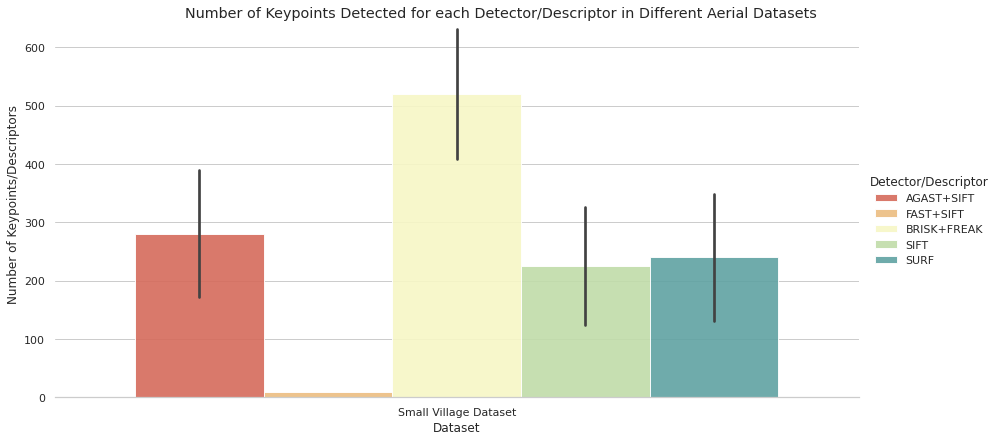

In [58]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_5, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Kypoints_8_{Dataset}.png')

In [59]:
df_numkey_5.to_csv(f'drive/MyDrive/Num_Kypoints_5_{Dataset}.csv')

In [60]:
print(len(num_matches_agast))

119


Total Number of Matches Detected for each Detector+Descriptor

In [61]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_sift + num_matches_surf + num_matches_freak + num_matches_agast + num_matches_fast, 'Detector/Descriptor': ['AGAST+SIFT']*(len_files-1) + ['SIFT']*(len_files-1) + ['BRISK+FREAK']*(len_files-1) + ['FAST+SIFT']*(len_files-1) + ['SURF']*(len_files-1)}
df_match_5 = pd.DataFrame(data=d)
df_match_5['Number of Total Matches'] = df_match_5['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

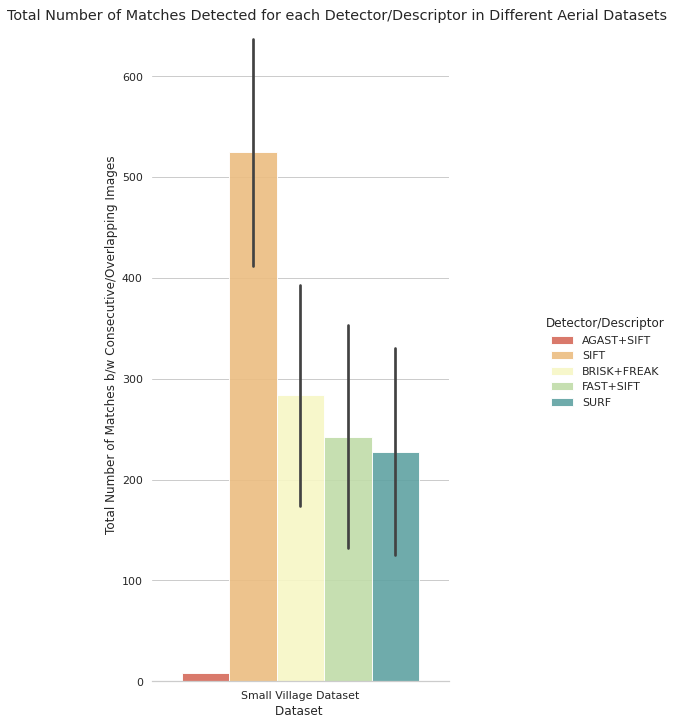

In [62]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Matches_8_{Dataset}.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Matches_16.csv')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [63]:
df_match_5['Number of Good Matches'] =  num_good_matches_sift + num_good_matches_surf + num_good_matches_freak + num_good_matches_agast + num_good_matches_fast
df_match_5['Number of Good Matches'] = df_match_5['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

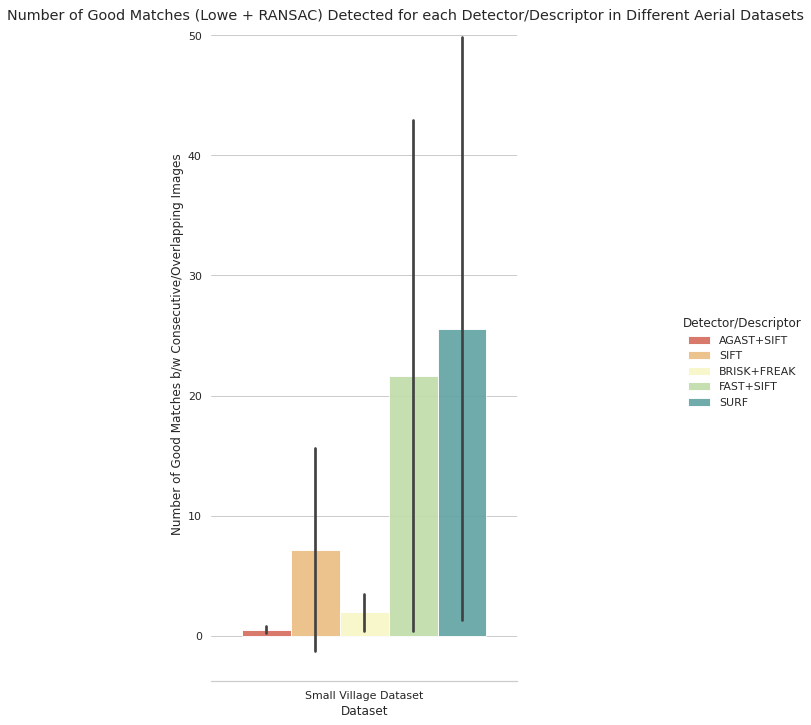

In [64]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig('drive/MyDrive/Num_Good_Matches_8.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Good_Matches_16.csv')

Recall Rate for each Detector+Descriptor

In [65]:
df_match_5['Recall Rate of Matches'] = df_match_5['Number of Good Matches']/df_match_5['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

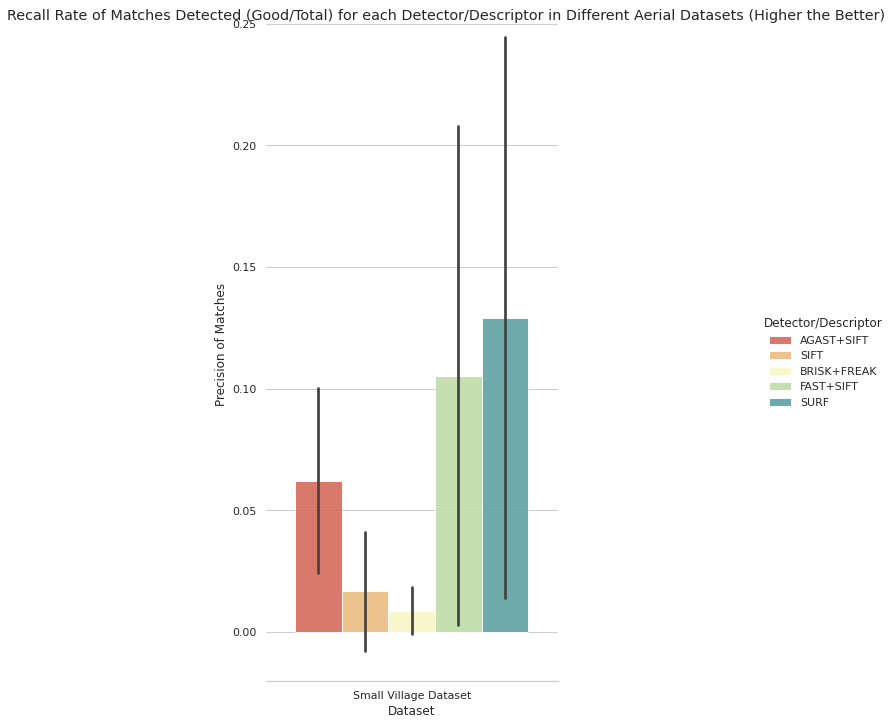

In [66]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/Recall_Rate_Matches_8.png')

1-Precision Rate for each Detector+Descriptor

In [67]:
df_match_5['1 - Precision Rate of Matches'] = (df_match_5['Number of Total Matches'] - df_match_5['Number of Good Matches'])/df_match_5['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

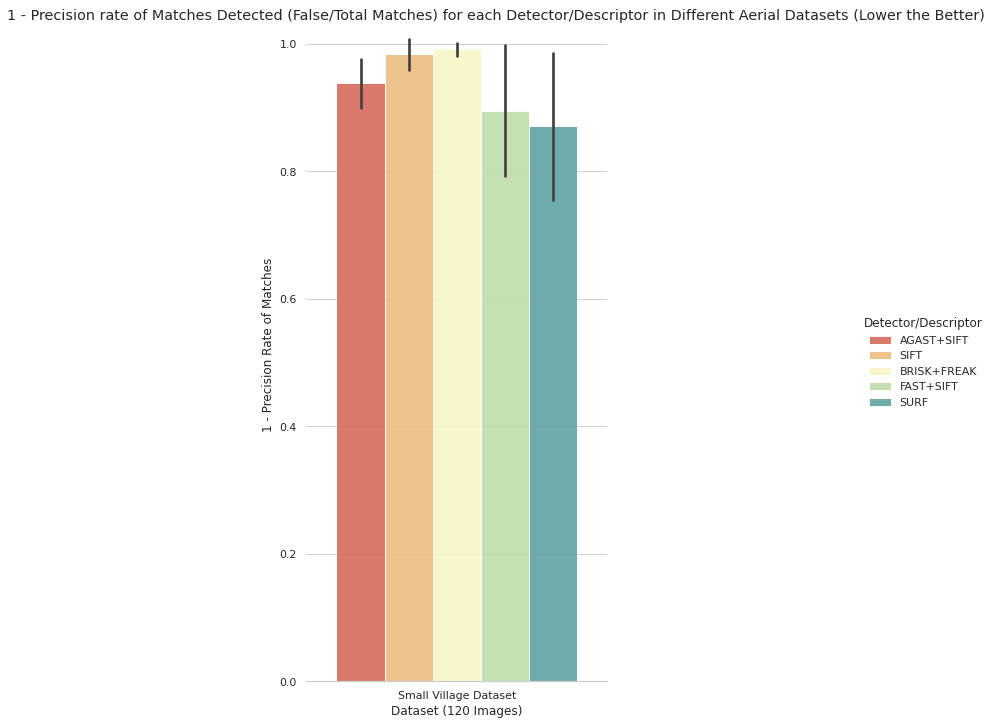

In [68]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5,kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/One_minus_Precision_Rate_Matches_8.png')

F-Score for each Detector+Descriptor

In [69]:
df_match_5['F-Score'] = (2* (1 - df_match_5['1 - Precision Rate of Matches']) * df_match_5['Recall Rate of Matches'])/((1 - df_match_5['1 - Precision Rate of Matches']) + df_match_5['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

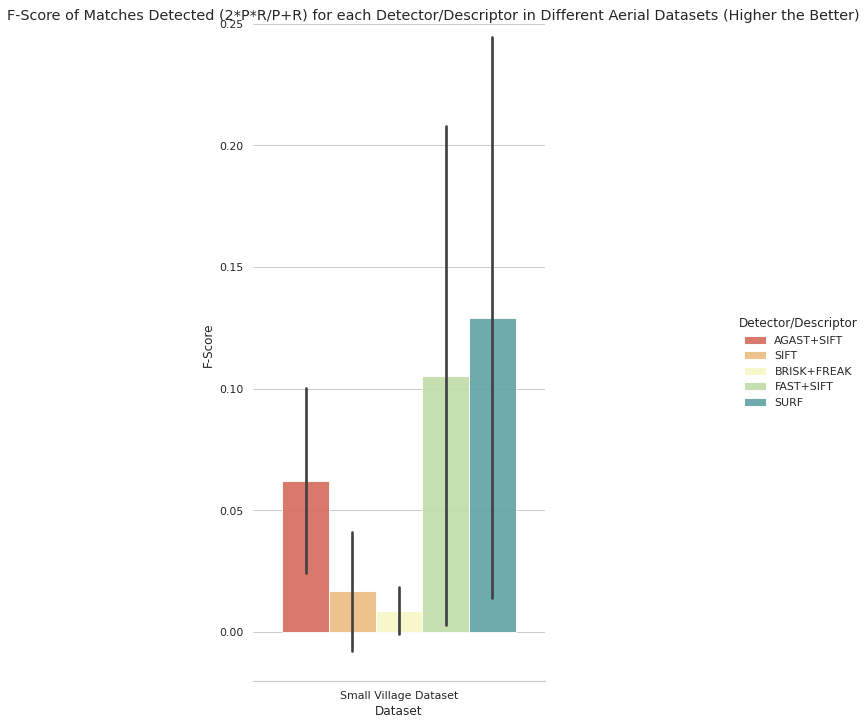

In [70]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/F_Score_Rate_Matches_8.png')

In [71]:
df_match_5.to_csv('drive/MyDrive/All_metrics_5.csv')

Time for each Detector+Descriptor

In [72]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time': [time_all[3]] + [time_all[0]] + [time_all[2]] + [time_all[1]] + [time_all[4]], 'Detector/Descriptor': ['AGAST+SIFT'] + ['FAST+SIFT']*(1) + ['BRISK+FREAK']*(1) + ['SURF']*(1) +  ['SIFT']*(1) }
df_time_5 = pd.DataFrame(data=d)

In [73]:
print(df_time_5)

                 Dataset        Time Detector/Descriptor
0  Small Village Dataset  268.800688          AGAST+SIFT
1  Small Village Dataset  143.548987           FAST+SIFT
2  Small Village Dataset  290.720178         BRISK+FREAK
3  Small Village Dataset  306.565612                SURF
4  Small Village Dataset  422.424870                SIFT


Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

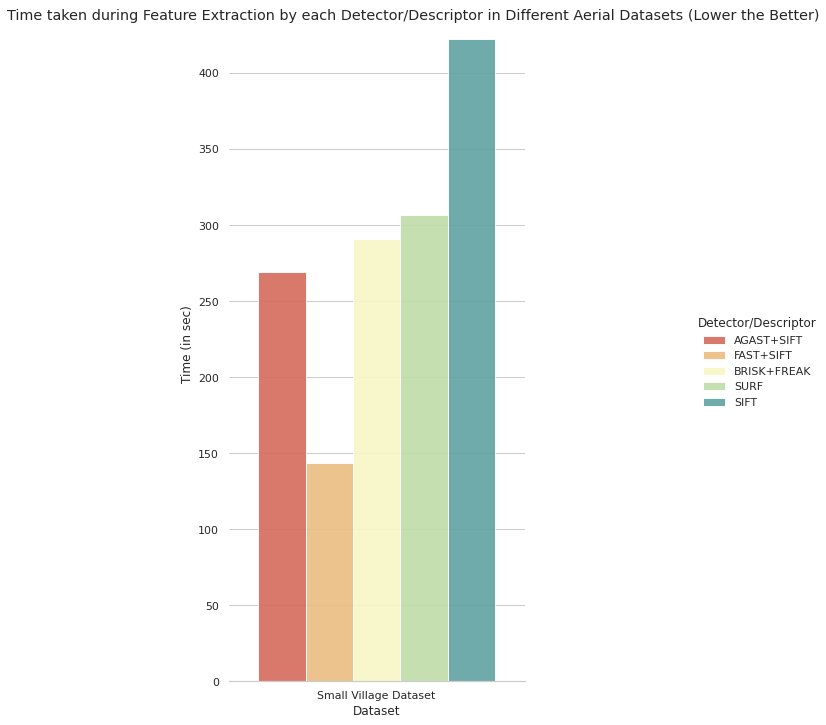

In [74]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_5, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/Time_8.png')

In [75]:
df_time_5.to_csv('drive/MyDrive/Time_5.csv')

Stitching with CPU